
# Análisis y Limpieza de Datos de NOx en CDMX (2020–2024)  

## 🎯 **Hipótesis**  
Las concentraciones de NOx (óxidos de nitrógeno) en la Ciudad de México presentan patrones estacionales predecibles, los cuales pueden modelarse efectivamente después de un proceso riguroso de limpieza e imputación de datos faltantes.  

> **Analogía**: Imagina los datos de contaminación como un rompecabezas. Algunas piezas (datos) están dañadas (-99) o faltantes (NaN), pero con las técnicas adecuadas podemos reconstruir la imagen completa sin distorsionar su significado original.  

## 🎯 **Objetivos**  
1. **Procesamiento**: Estandarizar los datos anuales de NOx (2020–2024) reportados por las 32 estaciones de monitoreo.  
2. **Limpieza**: Identificar y tratar valores atípicos y faltantes para garantizar la confiabilidad del análisis.  
3. **Automatización**: Crear un flujo reproducible aplicable a otros contaminantes (CO, O₃, PM2.5).  
4. **Modelado**: Evaluar la viabilidad de predicciones con SARIMA, identificando limitaciones y oportunidades de mejora.  

---

# **Paso 1: Carga de Datos** 📥  
Los datos se obtuvieron del portal de la *Dirección de Monitoreo Atmosférico de la CDMX*, organizados en archivos Excel (.xls) anuales. Cada archivo contiene:  
- **32 columnas**: Correspondientes a las estaciones de monitoreo.  
- **Columnas auxiliares**: Fecha, hora.  

Para un manejo eficiente, los datos se almacenan en un diccionario llamado `nox`, donde cada clave representa un año (`df20`, `df21`, ..., `df24`).  

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Carga de datos anuales
nox = {
    "df20": pd.read_excel("C:/Users/Lenovo/Desktop/Proyecto aire/NOX/2020NOX.xls"),
    "df21": pd.read_excel("C:/Users/Lenovo/Desktop/Proyecto aire/NOX/2021NOX.xls"),
    "df22": pd.read_excel("C:/Users/Lenovo/Desktop/Proyecto aire/NOX/2022NOX.xls"),
    "df23": pd.read_excel("C:/Users/Lenovo/Desktop/Proyecto aire/NOX/2023NOX.xls"),
    "df24": pd.read_excel("C:/Users/Lenovo/Desktop/Proyecto aire/NOX/2024NOX.xls")
}

# **Paso 2: Exploración Inicial** 🔍  
Una revisión rápida del DataFrame (`df20.head()`) permite verificar:  
- El formato de las columnas (estaciones, fecha, hora).  
- La presencia de valores nulos o marcadores especiales (ej. `-99`).  

---

In [3]:
nox["df20"].head()

FECHA  HORA  ACO  AJM  ATI  BJU  CAM  CCA  CHO  COY  ...  SAG  SFE  \
0 2020-01-01     1  -99  -99   32  -99   41   47  -99  -99  ...   35   16   
1 2020-01-01     2  -99  -99   41  -99   43   38  -99  -99  ...   45   23   
2 2020-01-01     3  -99  -99   55  -99   76   35  -99  -99  ...   39   15   
3 2020-01-01     4  -99  -99   52  -99   76   37  -99  -99  ...   29   16   
4 2020-01-01     5  -99  -99   44  -99   63   33  -99  -99  ...   31   13   

   SJA  TAH  TLA  TLI  UAX  UIZ  VIF  XAL  
0  -99   61   55   50   23   37   82  -99  
1  -99   55   36   57   28   38   77  -99  
2  -99   41   45   71   23   37  110  -99  
3  -99   28   53  103   19   22  100  -99  
4  -99   21   40  104   20   21   96  -99  

[5 rows x 36 columns]

In [4]:
nox["df20"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FECHA   8784 non-null   datetime64[ns]
 1   HORA    8784 non-null   int64         
 2   ACO     8784 non-null   int64         
 3   AJM     8784 non-null   int64         
 4   ATI     8784 non-null   int64         
 5   BJU     8784 non-null   int64         
 6   CAM     8784 non-null   int64         
 7   CCA     8784 non-null   int64         
 8   CHO     8784 non-null   int64         
 9   COY     8784 non-null   int64         
 10  CUA     8784 non-null   int64         
 11  CUT     8784 non-null   int64         
 12  FAC     8784 non-null   int64         
 13  FAR     8784 non-null   int64         
 14  HGM     8784 non-null   int64         
 15  INN     8784 non-null   int64         
 16  IZT     8784 non-null   int64         
 17  LLA     8784 non-null   int64         
 18  LPR     

# **Paso 3: Limpieza Básica y Desglose Temporal** 🛠️  

## **Problema Identificado**  
El valor `-99` se usa como marcador de datos inválidos o faltantes. Para un análisis correcto, estos deben convertirse a `NaN` (estándar en pandas).  

### **Mejoras Logradas**  
1. **Consistencia**: Datos faltantes uniformes (`NaN`).  
2. **Flexibilidad**: Permite aplicar técnicas de imputación.  
3. **Enriquecimiento Temporal**: Se agregaron columnas para análisis estacional:  
   - `AÑO`, `MES`, `DÍA_SEMANA`, `HORA_AJUSTADA`, `FECHA_HORA`. 

In [5]:
def reemplazo_datos(diccionario):
    """
    Reemplaza los valores -99 por np.nan en todos los DataFrames del diccionario.

    Parámetros:
        diccionario (dict): Diccionario donde cada clave es un año (ej. 'df20') 
                            y cada valor es un DataFrame con datos de NOx.

    Retorna:
        dict: Diccionario con los DataFrames modificados (sin valores -99).
    """
    for clave in diccionario:
        dataframe = diccionario[clave] 
        diccionario[clave] = dataframe.replace(-99, np.nan)
    return diccionario

In [6]:
nox = reemplazo_datos(nox)
nox["df20"].head()

FECHA  HORA  ACO  AJM   ATI  BJU   CAM   CCA  CHO  COY  ...   SAG  \
0 2020-01-01     1  NaN  NaN  32.0  NaN  41.0  47.0  NaN  NaN  ...  35.0   
1 2020-01-01     2  NaN  NaN  41.0  NaN  43.0  38.0  NaN  NaN  ...  45.0   
2 2020-01-01     3  NaN  NaN  55.0  NaN  76.0  35.0  NaN  NaN  ...  39.0   
3 2020-01-01     4  NaN  NaN  52.0  NaN  76.0  37.0  NaN  NaN  ...  29.0   
4 2020-01-01     5  NaN  NaN  44.0  NaN  63.0  33.0  NaN  NaN  ...  31.0   

    SFE  SJA   TAH   TLA    TLI   UAX   UIZ    VIF  XAL  
0  16.0  NaN  61.0  55.0   50.0  23.0  37.0   82.0  NaN  
1  23.0  NaN  55.0  36.0   57.0  28.0  38.0   77.0  NaN  
2  15.0  NaN  41.0  45.0   71.0  23.0  37.0  110.0  NaN  
3  16.0  NaN  28.0  53.0  103.0  19.0  22.0  100.0  NaN  
4  13.0  NaN  21.0  40.0  104.0  20.0  21.0   96.0  NaN  

[5 rows x 36 columns]

In [7]:
def extender_datos_tiempo (diccionario):
    """
    Extender cada DataFrame del diccionario con columnas temporales:
    AÑO, MES (nombre), DÍA_SEMANA (nombre), HORA_AJUSTADA, FECHA_HORA.
    Elimina las columnas FECHA y HORA originales.

    Parámetros:
    diccionario (dict): Diccionario con DataFrames por año.

    Retorna:
    dict: Diccionario actualizado con columnas temporales agregadas.
    """
    meses = ["", "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
             "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
    dias_semana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

    for clave in diccionario:
        df = diccionario[clave].copy()

        # Columnas temporales
        df["AÑO"] = df["FECHA"].dt.year
        df["MES"] = df["FECHA"].dt.month.map(lambda x: meses[x])
        df["DÍA_SEMANA"] = df["FECHA"].dt.weekday.map(lambda x: dias_semana[x])
        df["HORA_AJUSTADA"] = df["HORA"] - 1

        # Crear columna FECHA_HORA usando HORA_AJUSTADA
        df["FECHA_HORA"] = pd.to_datetime(df["FECHA"]) + pd.to_timedelta(df["HORA_AJUSTADA"], unit="h")

        # Eliminar columnas originales
        df.drop(columns=["FECHA", "HORA"], inplace=True)

        # Reordenar columnas
        columnas_ordenadas = ["FECHA_HORA", "AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"] + \
                             [col for col in df.columns if col not in ["FECHA_HORA", "AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"]]
        df = df[columnas_ordenadas]

        diccionario[clave] = df

    return diccionario

In [8]:
nox = extender_datos_tiempo(nox)
nox["df20"].head()

FECHA_HORA   AÑO    MES DÍA_SEMANA  HORA_AJUSTADA  ACO  AJM   ATI  \
0 2020-01-01 00:00:00  2020  Enero  Miércoles              0  NaN  NaN  32.0   
1 2020-01-01 01:00:00  2020  Enero  Miércoles              1  NaN  NaN  41.0   
2 2020-01-01 02:00:00  2020  Enero  Miércoles              2  NaN  NaN  55.0   
3 2020-01-01 03:00:00  2020  Enero  Miércoles              3  NaN  NaN  52.0   
4 2020-01-01 04:00:00  2020  Enero  Miércoles              4  NaN  NaN  44.0   

   BJU   CAM  ...   SAG   SFE  SJA   TAH   TLA    TLI   UAX   UIZ    VIF  XAL  
0  NaN  41.0  ...  35.0  16.0  NaN  61.0  55.0   50.0  23.0  37.0   82.0  NaN  
1  NaN  43.0  ...  45.0  23.0  NaN  55.0  36.0   57.0  28.0  38.0   77.0  NaN  
2  NaN  76.0  ...  39.0  15.0  NaN  41.0  45.0   71.0  23.0  37.0  110.0  NaN  
3  NaN  76.0  ...  29.0  16.0  NaN  28.0  53.0  103.0  19.0  22.0  100.0  NaN  
4  NaN  63.0  ...  31.0  13.0  NaN  21.0  40.0  104.0  20.0  21.0   96.0  NaN  

[5 rows x 39 columns]

# **Paso 4: Visualización del Comportamiento de los datos** 📊  
---

### 🎯 Objetivo

El propósito de este módulo es analizar visualmente los datos históricos para detectar patrones estacionales en las concentraciones de NOx en la Ciudad de México. Identificar estos patrones permitiría justificar el uso de modelos predictivos como SARIMA, aprovechando la naturaleza diaria y horaria de la recolección de datos.

Para evitar sesgos o interpretaciones erróneas, se graficarán únicamente las estaciones que cuentan con al menos el 80% de datos válidos. Posteriormente, se evaluará si los datos correspondientes al año 2024 conservan estos patrones estacionales y si son aptos para modelado.

---

### 🧱 Estructura del Proceso

Se trabajará con tres DataFrames principales, cada uno con un propósito específico:

| DataFrame        | Contenido                                      | Propósito                                                                 |
|------------------|------------------------------------------------|---------------------------------------------------------------------------|
| `df_completo`    | Datos brutos 2020-2024 (sin imputar)          | Análisis histórico y detección de fallos en estaciones                   |
| `df_global_filtrado` | Estaciones con ≥80% de datos válidos (2020-2024) | Visualizar patrones estacionales confiables                              |
| `df_2024`        | Estaciones con ≥80% de datos válidos en 2024   | Evaluar si los patrones recientes permiten modelado predictivo           |

---

### 🔄 Flujo de Trabajo

```mermaid
graph TD
    A[Unir datos anuales] --> B[Filtrar estaciones con ≥80% datos]
    B --> C[Visualizar patrones mensuales/semanales/horarios]
    C --> D[Analizar 2024 para modelado]
```

---

1. **Unión de Datos Originales**  
   - Se copian los DataFrames por año desde el diccionario original.  
   - Se concatenan en un único DataFrame llamado `df_completo`.

2. **Evaluación de Completitud Global**  
   - Se calcula el porcentaje de datos válidos por estación en el conjunto histórico.  
   - Se seleccionan aquellas con ≥80% de datos para análisis estacional (`df_filtrado`).

3. **Visualización del Comportamiento**  
   - Se generan gráficos individuales por estación:  
     - Boxplots por mes, día de la semana y hora del día  
     - Series temporales anuales para evaluar estacionalidad

4. **Análisis del Año 2024**  
   - Se filtran las estaciones con ≥80% de datos válidos en 2024 (`df_2024`).  
   - Se visualiza su comportamiento para determinar si conservan patrones estacionales.  
   - Se evalúa si es viable aplicar modelos predictivos sobre este subconjunto.

---

### 📌 Justificación Técnica

- **Separación de roles**: Evita contaminación cruzada entre datos brutos, filtrados e imputados, manteniendo claridad en el análisis.
- **Trazabilidad**: Cada etapa del procesamiento está documentada, facilitando auditoría y replicabilidad.
- **Visualización como evidencia**: Los gráficos permiten validar la calidad de los datos y justificar decisiones técnicas como la imputación o el modelado.

---

In [9]:
# Concatenar todos los años
df_completo = pd.concat(nox.values(), axis=0, ignore_index=True)

---

## 📌 **Flujo de Trabajo**  

```mermaid
graph TD
    A[Verificar completitud] --> B{Winsorizar outliers?}
    B -->|Sí| C[Reemplazar extremos con límites IQR]
    B -->|No| D[Descartar estación]
    C --> E[Validar conservación de patrones]
```

---

In [10]:
def filtrar_por_completitud(dataframe,total_registros):
    """
    Filtra las columnas del DataFrame que tienen al menos 80% de datos válidos.

    Parámetros:
    - DataFrame: DataFrame completo con columnas de estaciones y auxiliares.

    Retorna:
    - df_filtrado (DataFrame): DataFrame con columnas seleccionadas.
    """
    columnas_auxiliares = ["FECHA_HORA", "AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"]
    columnas_estaciones = [col for col in dataframe.columns if col not in columnas_auxiliares]


    columnas_validas = [
        col for col in columnas_estaciones
        if (dataframe[col].count() / total_registros) * 100 >= 80
    ]

    columnas_finales = columnas_auxiliares + columnas_validas
    df_filtrado = dataframe[columnas_finales].copy()

    return df_filtrado

In [11]:
# Aplicar filtro (43824 registros esperados en 5 años )
df_global_filtrado = filtrar_por_completitud(df_completo,43824)

In [12]:
df_global_filtrado

FECHA_HORA   AÑO        MES DÍA_SEMANA  HORA_AJUSTADA   CCA  \
0     2020-01-01 00:00:00  2020      Enero  Miércoles              0  47.0   
1     2020-01-01 01:00:00  2020      Enero  Miércoles              1  38.0   
2     2020-01-01 02:00:00  2020      Enero  Miércoles              2  35.0   
3     2020-01-01 03:00:00  2020      Enero  Miércoles              3  37.0   
4     2020-01-01 04:00:00  2020      Enero  Miércoles              4  33.0   
...                   ...   ...        ...        ...            ...   ...   
40163 2024-12-31 19:00:00  2024  Diciembre     Martes             19  32.0   
40164 2024-12-31 20:00:00  2024  Diciembre     Martes             20  20.0   
40165 2024-12-31 21:00:00  2024  Diciembre     Martes             21  37.0   
40166 2024-12-31 22:00:00  2024  Diciembre     Martes             22  39.0   
40167 2024-12-31 23:00:00  2024  Diciembre     Martes             23  29.0   

        FAC   MER   MGH  
0      33.0  40.0   NaN  
1      45.0  41.0   NaN  
2      53.0  43.0   NaN  
3      58.0  83.0   NaN  
4      55.0  69.0   NaN  
...     ...   ...   ...  
40163  38.0   NaN  44.0  
40164  39.0   NaN  43.0  
40165  47.0   NaN  36.0  
40166  27.0   NaN  29.0  
40167  20.0   NaN  21.0  

[40168 rows x 9 columns]

### **2. Visualización con Boxplots por estacion** 

In [13]:
def mostrar_boxplots_por_estacion(dataframe):
    """
    Genera boxplots para cada estación, mostrando distribución de NOx por:
    - Mes
    - Día de la semana
    - Hora del día

    Parámetros:
        dataframe (pd.DataFrame): DataFrame con columnas de estaciones y metadatos temporales.
    """
    # Configurar órdenes lógicos
    meses_ordenados = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    dias_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

    dataframe["MES"] = pd.Categorical(dataframe["MES"], categories=meses_ordenados, ordered=True)
    dataframe["DÍA_SEMANA"] = pd.Categorical(dataframe["DÍA_SEMANA"], categories=dias_ordenados, ordered=True)

    # Identificar estaciones (excluyendo columnas auxiliares)
    estaciones = [col for col in dataframe.columns if col not in ["FECHA_HORA", "AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"]]

    for estacion in estaciones:
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 fila, 3 gráficos

        # Boxplot mensual
        sns.boxplot(x="MES", y=estacion, data=dataframe, ax=axes[0])
        axes[0].set_title("Variación Mensual")
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True)

        # Boxplot semanal
        sns.boxplot(x="DÍA_SEMANA", y=estacion, data=dataframe, ax=axes[1])
        axes[1].set_title("Variación Semanal")
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True)

        # Boxplot horario
        sns.boxplot(x="HORA_AJUSTADA", y=estacion, data=dataframe, ax=axes[2])
        axes[2].set_title("Variación Horaria")
        axes[2].grid(True)

        fig.suptitle(f"Distribución de NOx - Estación {estacion}", fontsize=14)
        plt.tight_layout()
        plt.show()


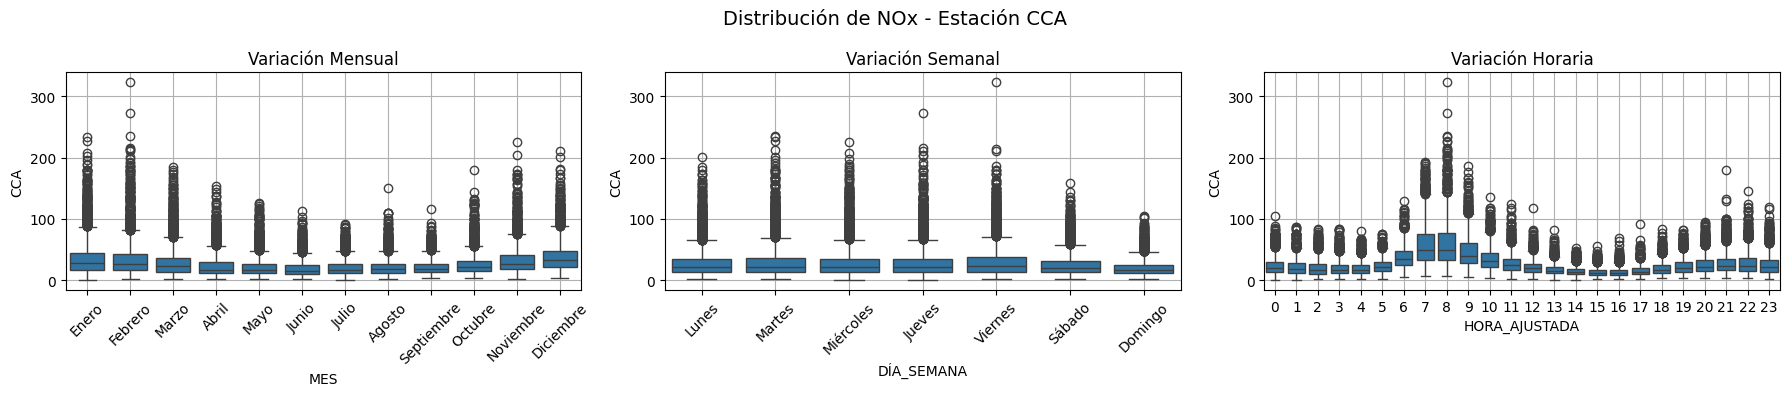

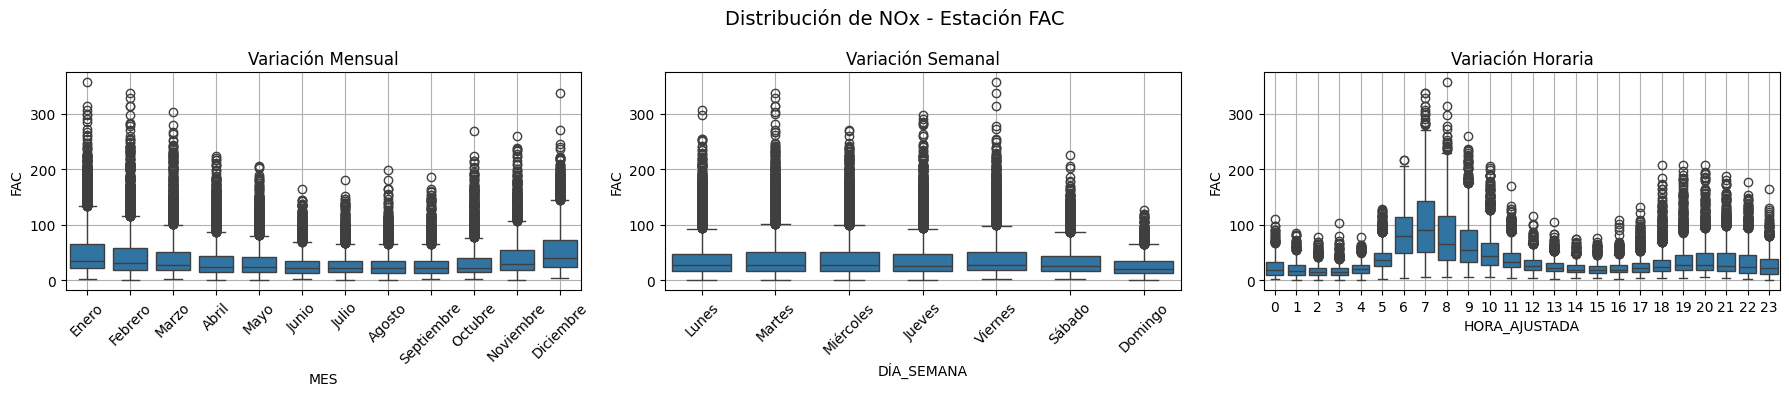

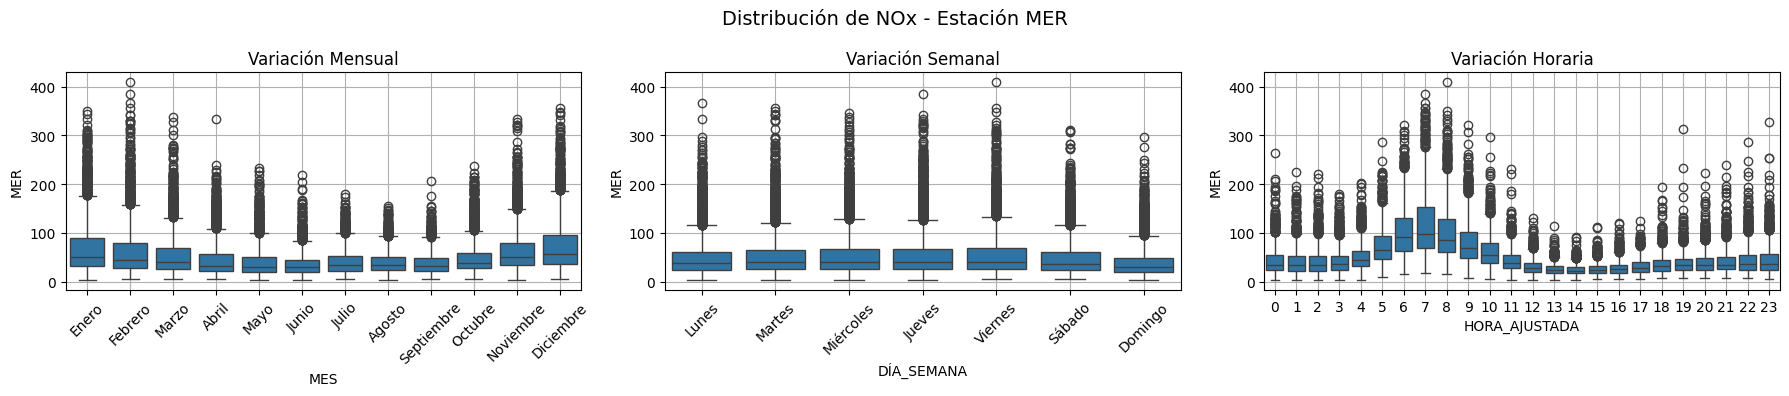

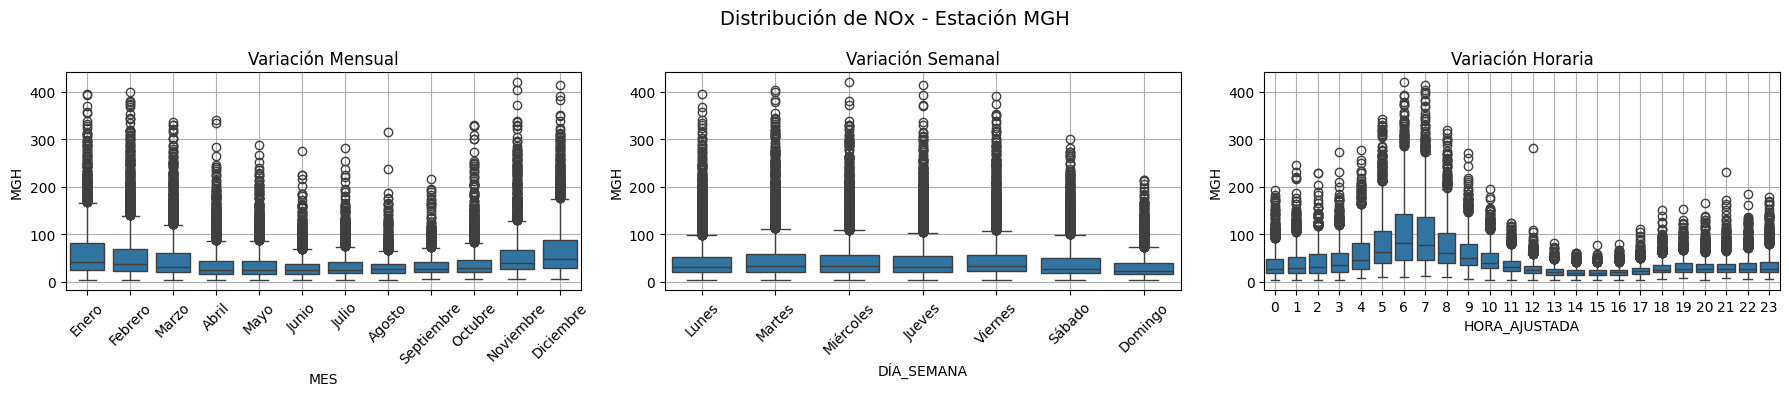

In [14]:
mostrar_boxplots_por_estacion(df_global_filtrado)

## 🎯 **Hallazgos Clave**  
### 1️⃣ Indicios de estacionalidad:
- Meses fríos (Enero, Febrero, Noviembre, Diciembre) → Altas concentraciones de NOx.
- Meses cálidos (Abril a Septiembre) → Niveles más bajos y más homogéneos.

### 2️⃣ Comportamiento estadístico:
- Outliers en todos los meses, pero más frecuentes y extremos en invierno.
- Asimetría positiva constante, con eventos de alta concentración aislados.
- IQR amplio en meses fríos, lo que refleja mayor variabilidad ambiental.

### Variabilidad Diaria**:  
  - 🚗 **Horas pico en el intervalo de 6-9 am**
  - 📊 **Segundo incremento, menos elevado, en el intervalo de 18- 23**
  - 🌙 **Noches**: Concentraciones más bajas pero con comportamiento visible.
  
### 📌 ¿Qué significa esto?
- Hay evidencia clara de estacionalidad anual, posiblemente vinculada al tráfico urbano, clima frío y dinámica social/laboral.

### **Análisis para 2024** 

In [15]:
df_2024 = df_completo[df_completo["FECHA_HORA"].dt.year == 2024]
df_2024 =filtrar_por_completitud(df_2024,8784) # 8760 registros esperados en 1 año, 8784 para años bisiestos
df_2024

FECHA_HORA   AÑO        MES DÍA_SEMANA  HORA_AJUSTADA   AJM  \
31392 2024-01-01 00:00:00  2024      Enero      Lunes              0  10.0   
31393 2024-01-01 01:00:00  2024      Enero      Lunes              1   9.0   
31394 2024-01-01 02:00:00  2024      Enero      Lunes              2   9.0   
31395 2024-01-01 03:00:00  2024      Enero      Lunes              3   9.0   
31396 2024-01-01 04:00:00  2024      Enero      Lunes              4   7.0   
...                   ...   ...        ...        ...            ...   ...   
40163 2024-12-31 19:00:00  2024  Diciembre     Martes             19  20.0   
40164 2024-12-31 20:00:00  2024  Diciembre     Martes             20  45.0   
40165 2024-12-31 21:00:00  2024  Diciembre     Martes             21  34.0   
40166 2024-12-31 22:00:00  2024  Diciembre     Martes             22  16.0   
40167 2024-12-31 23:00:00  2024  Diciembre     Martes             23  11.0   

        CCA   CUA   CUT   FAC   IZT    MER   MGH    SAC   TLI    VIF  
31392  38.0  17.0  31.0  32.0  59.0   70.0  29.0   66.0  54.0   70.0  
31393  35.0  30.0  36.0  68.0  70.0   92.0  78.0   76.0  54.0   91.0  
31394  54.0  33.0  28.0  66.0  71.0  132.0  67.0   97.0  83.0  103.0  
31395  42.0  28.0  20.0  46.0  81.0  108.0  68.0  124.0  70.0   81.0  
31396  31.0  18.0  19.0  35.0  69.0   87.0  61.0   89.0  68.0   81.0  
...     ...   ...   ...   ...   ...    ...   ...    ...   ...    ...  
40163  32.0  79.0  45.0  38.0  66.0    NaN  44.0   43.0  28.0   21.0  
40164  20.0  33.0  39.0  39.0  37.0    NaN  43.0   46.0  30.0   26.0  
40165  37.0  26.0  43.0  47.0  30.0    NaN  36.0   42.0  36.0   33.0  
40166  39.0  28.0  45.0  27.0  44.0    NaN  29.0   50.0  57.0   52.0  
40167  29.0  25.0  37.0  20.0  36.0    NaN  21.0   74.0  51.0   73.0  

[8776 rows x 16 columns]

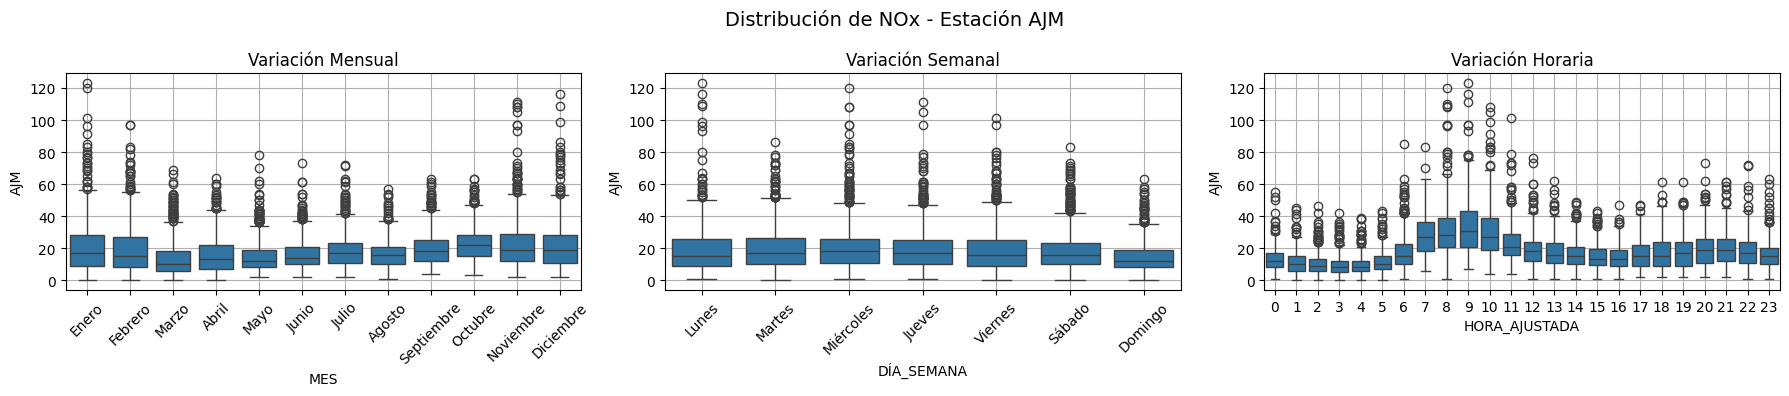

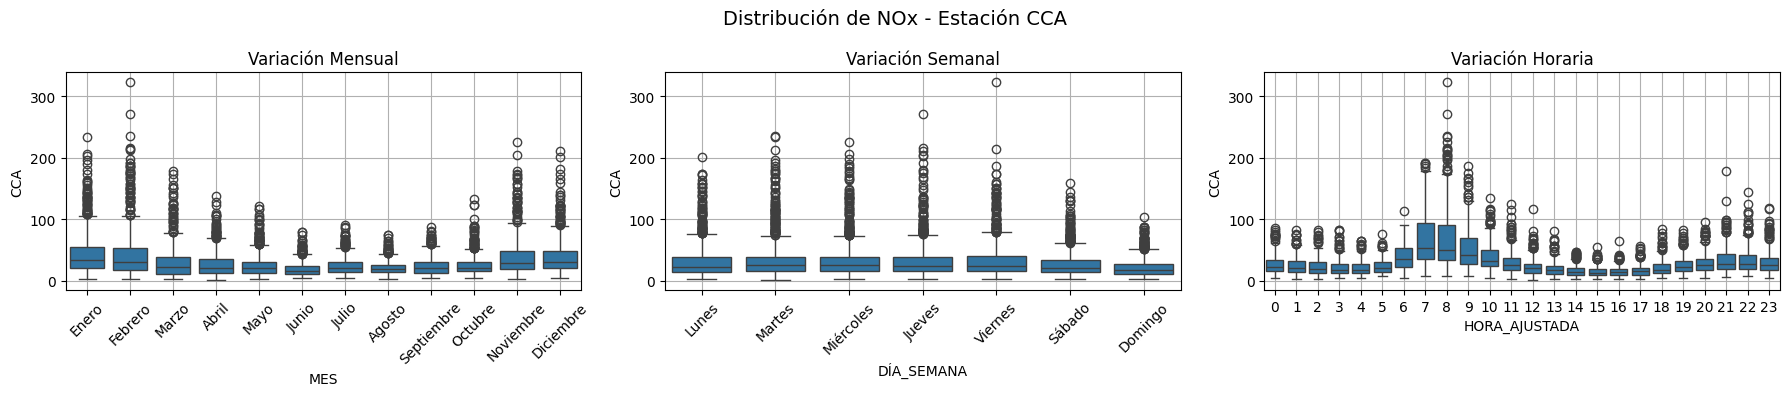

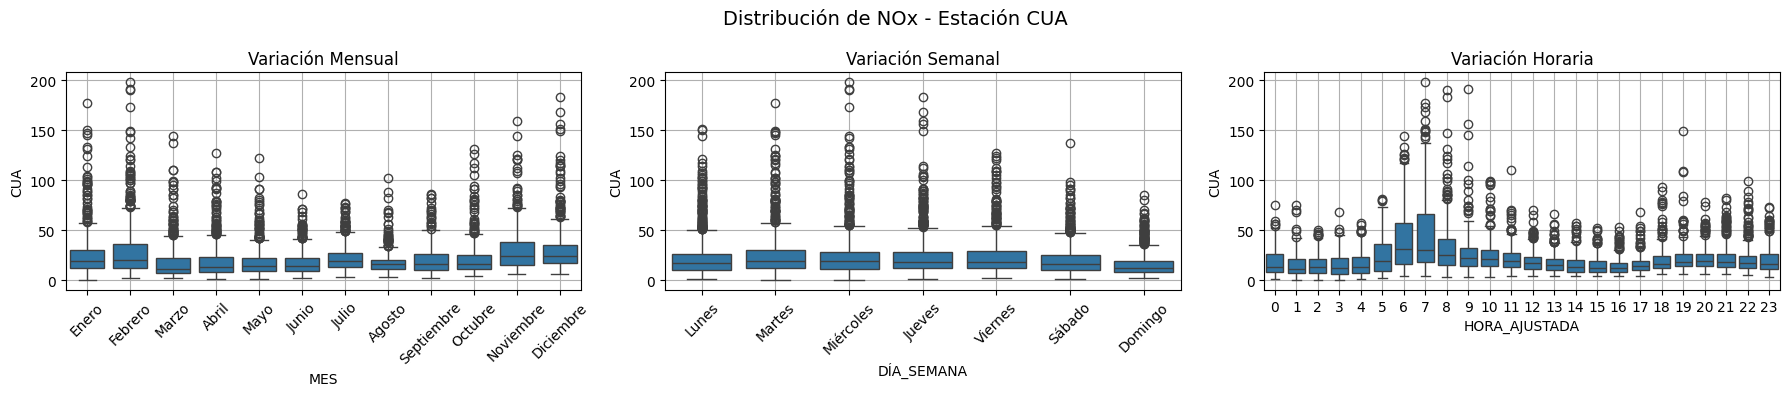

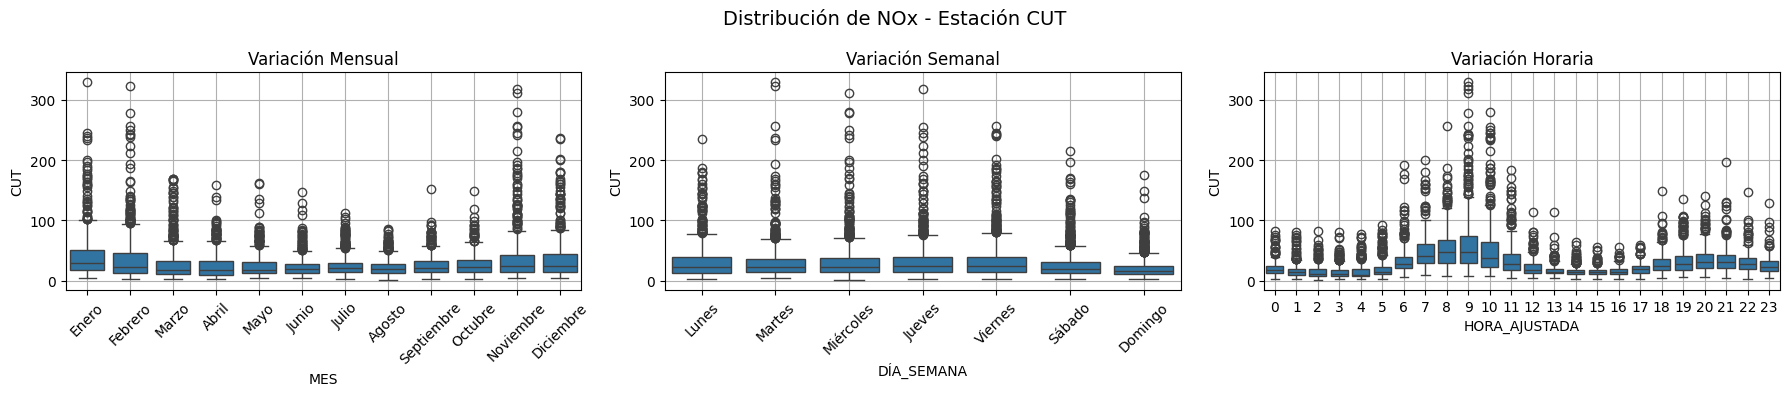

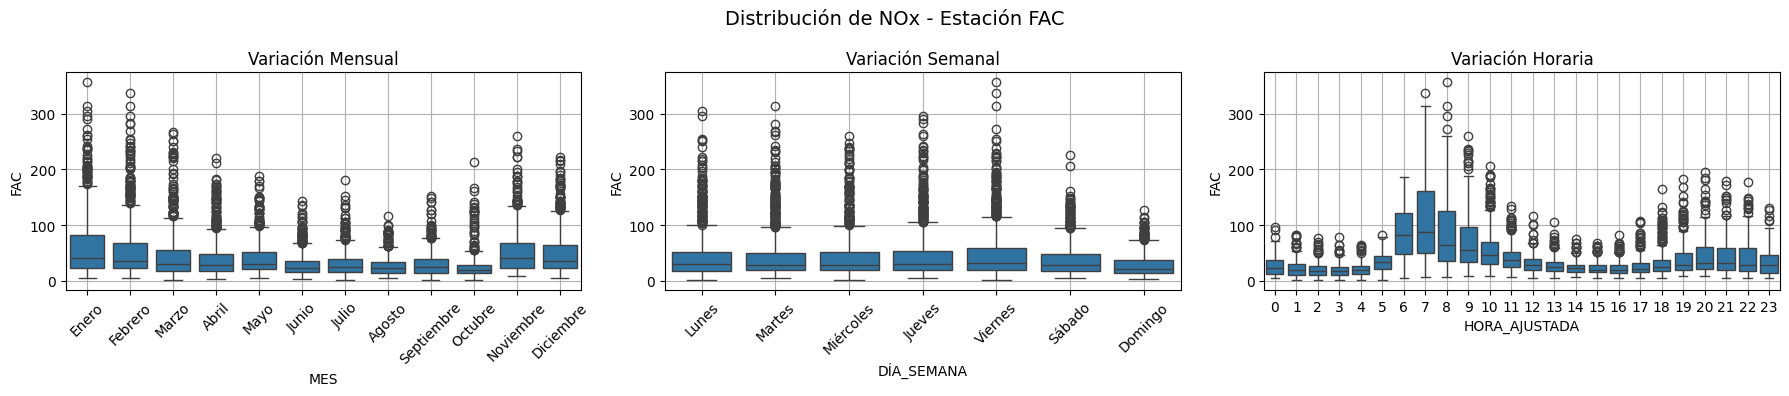

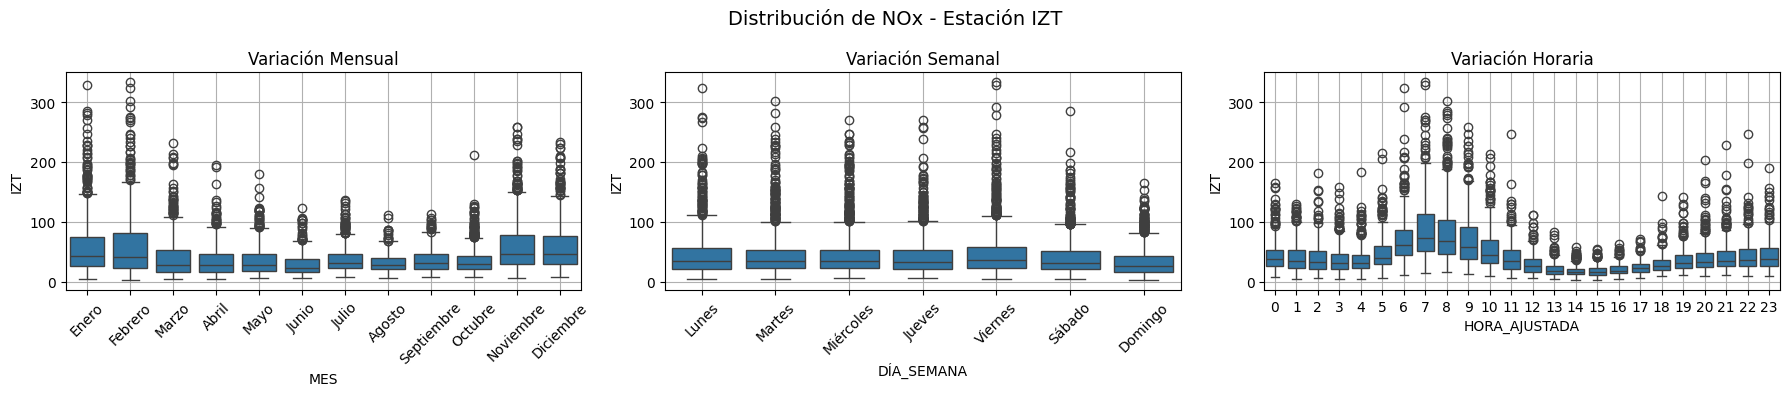

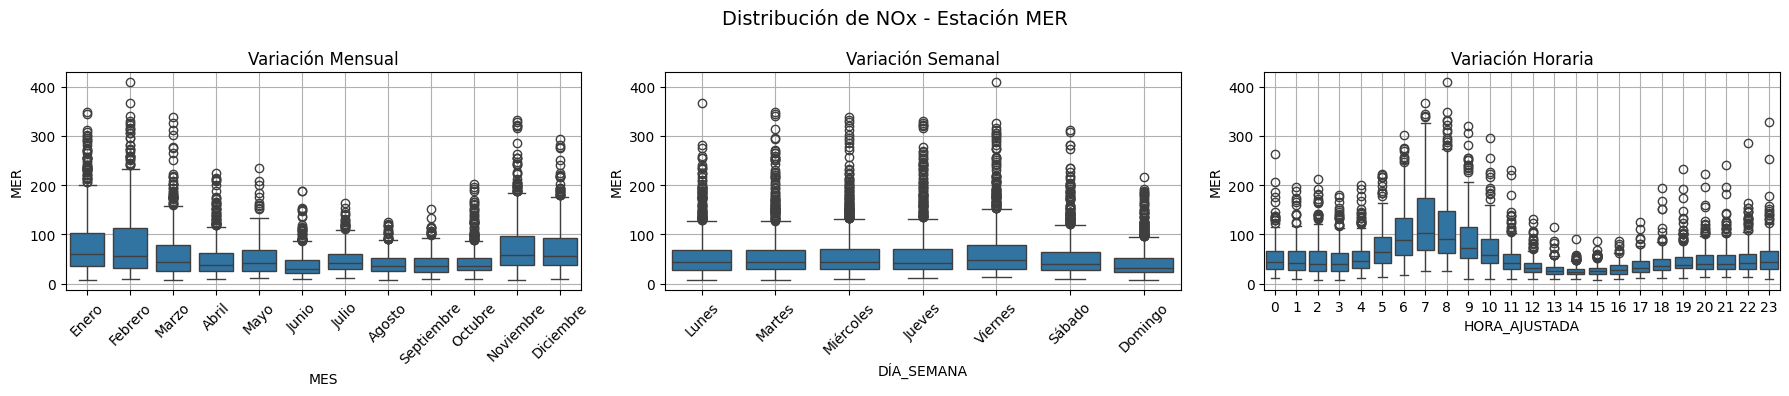

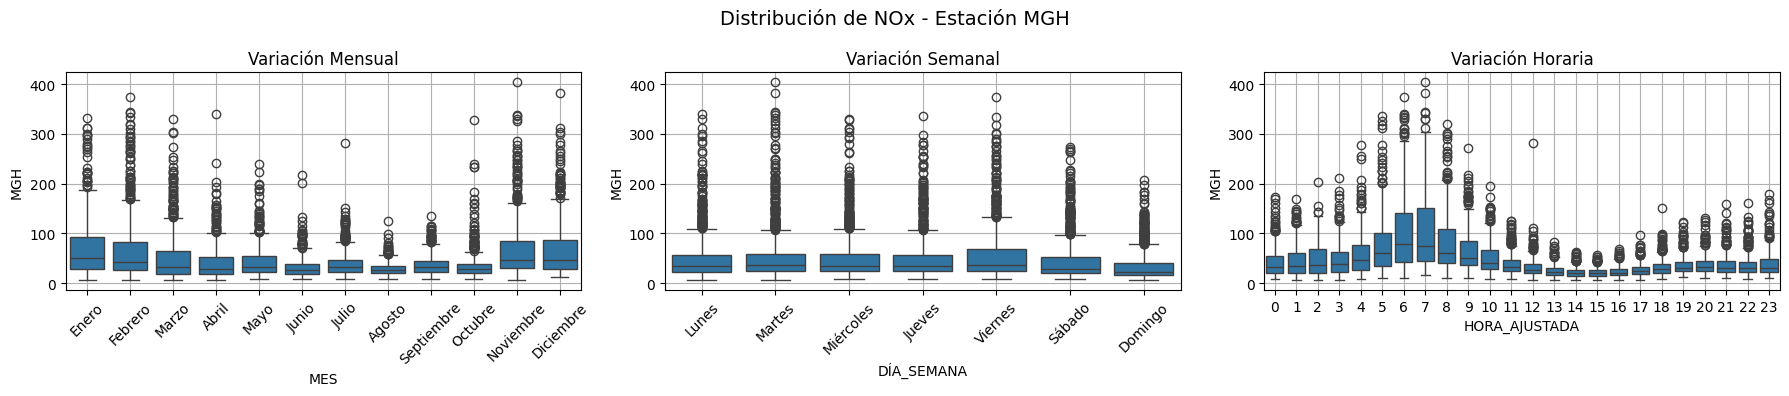

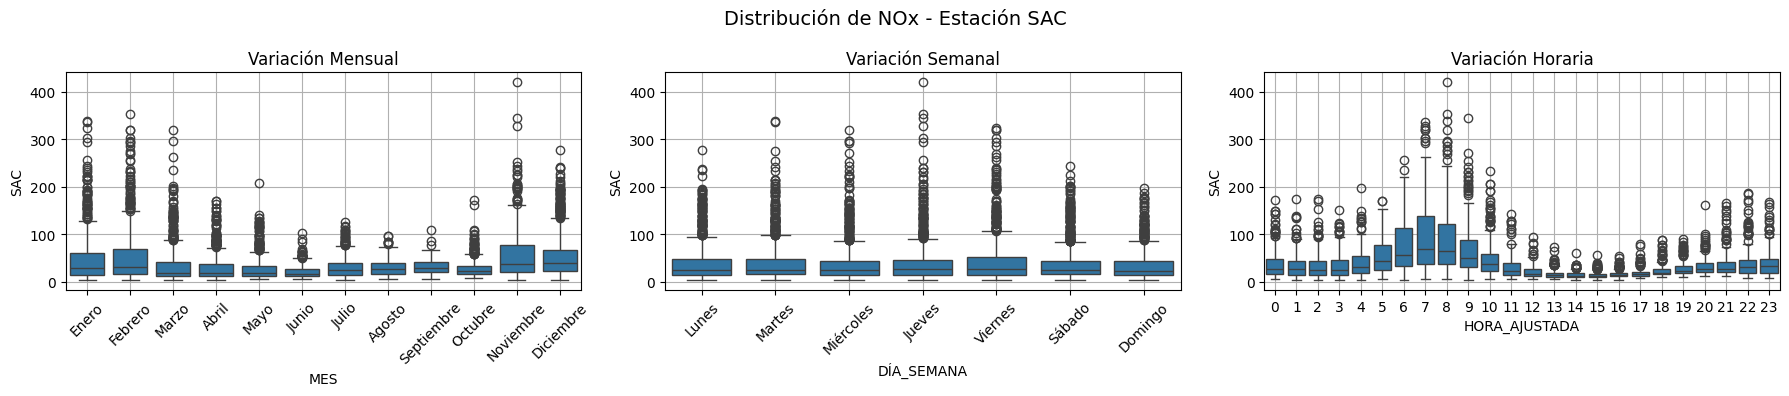

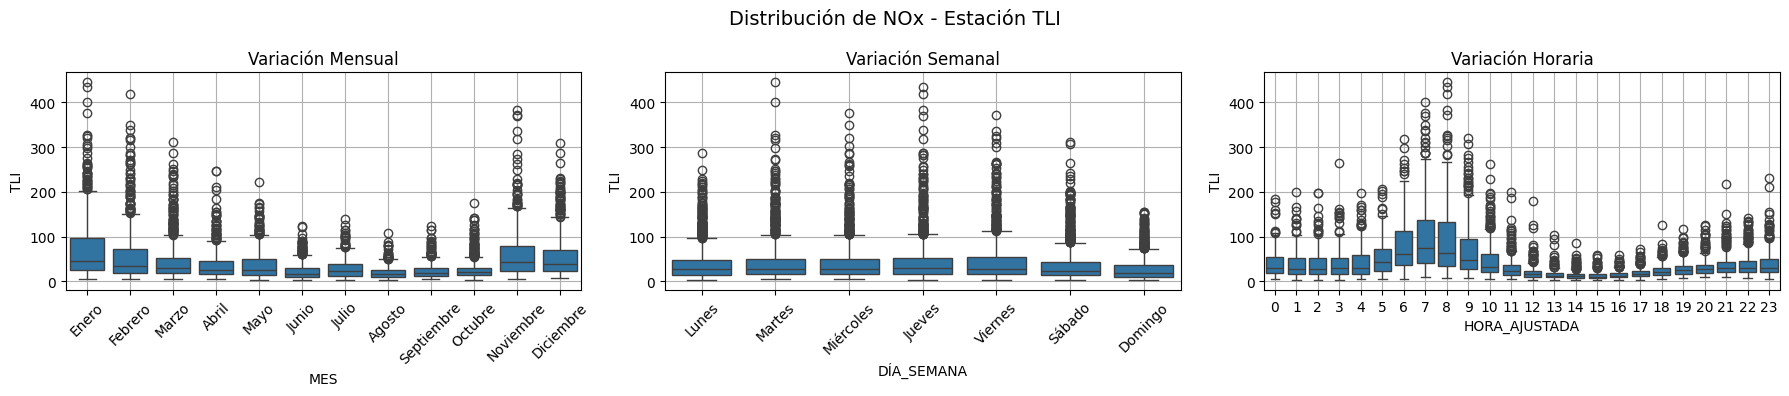

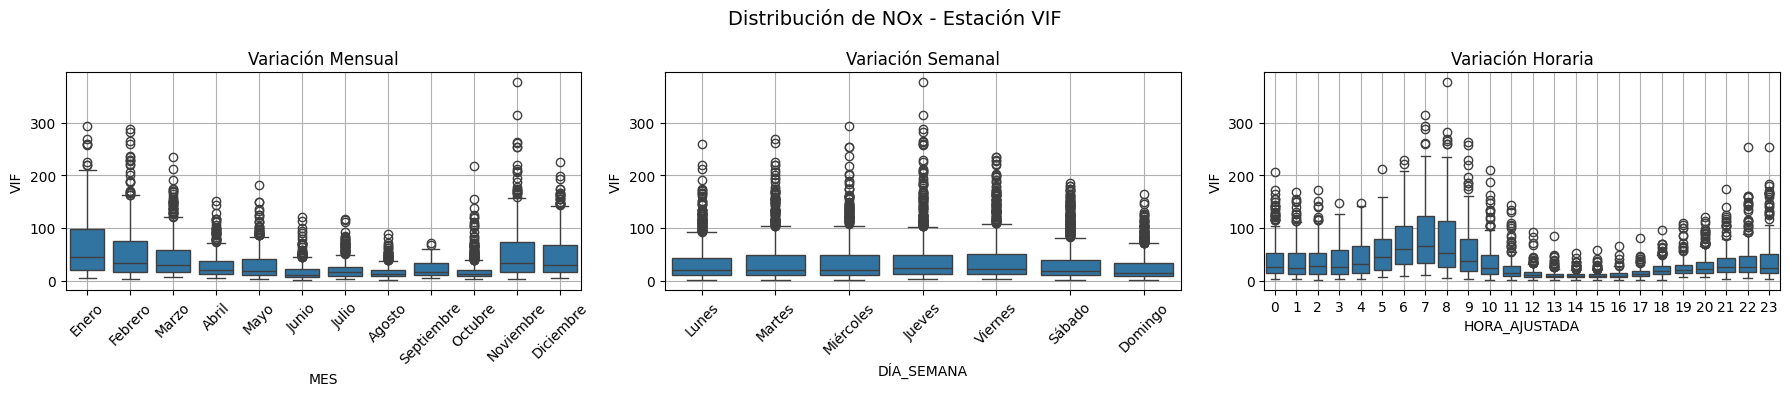

In [16]:
mostrar_boxplots_por_estacion(df_2024)

## 🎯 Hallazgos del Boxplot del 2024
- El patron estacionario que se vio en las graficas globales se conserva
- Justifica técnicas de imputación estacional, como interpolaciones por mes o medias horarias.
- Abre la puerta a modelado con SARIMA, que pueden incorporar efectos estacionales anuales.
- (`S=24` para periodicidad horaria, `S=168` para semanal) son justificables.  
- La estacionalidad anual sugiere incluir `D=12` en el parámetro `seasonal_order`.  

  

# **Paso 5: Tratamiento de Outliers y Validación de Completitud** 

## 🎯 **Objetivos**  
1. **Garantizar calidad de datos**:  
   - Identificar y corregir valores atípicos que puedan distorsionar el modelado.  
   - Verificar que las estaciones cumplan con el umbral mínimo de completitud (≥80%).  

2. **Preservar patrones naturales**:  
   - Aplicar técnicas que mantengan la estacionalidad horaria/semanal.  
   - Evitar introducir sesgos artificiales durante la imputación. 

Antes de aplicar un modelo predictivo como SARIMA, es fundamental garantizar que la serie temporal sea continua, regular y representativa. Aunque el conjunto de datos correspondiente al año 2024 presenta una cobertura aceptable en la mayoría de las estaciones (≥80% de datos válidos), aún existen valores faltantes que podrían distorsionar el análisis si no se tratan adecuadamente.

Para preservar la estacionalidad horaria y semanal de las concentraciones de NOx, se optó por imputar los valores faltantes utilizando  **winsorizar**. Esta técnica permite identificar y corregir outliers, 
reemplazando los valores extremos con un valor límite (el "tope"). Esto conserva la señal de que ocurrió un evento de alta contaminación, pero evita que su magnitud extrema distorsione los parámetros del modelo.
<br>De esta forma:

- Se evita introducir sesgos artificiales.
- Se conserva la estructura temporal de la serie.
- Se mejora la calidad del dataset para modelado sin alterar su comportamiento natural.

La imputación se aplicará únicamente a las estaciones que cumplen con el umbral mínimo de completitud (≥80%). Las estaciones que no alcanzan este umbral serán excluidas del modelado para evitar resultados poco confiables.


## **2. Winsorización de Outliers**  

### 🛠️ **Técnica Aplicada**  
**Winsorización con IQR**:  
- Reemplaza valores extremos por percentiles (límites inferior/superior).  
- **Ventajas**:  
  - Conserva la ocurrencia de eventos extremos (ej. contingencias ambientales).  
  - Reduce el impacto de mediciones erróneas en el modelo.  

In [17]:
def winsorizar_iqr(dataframe):
    """
    Aplica winsorización a todas las estaciones del DataFrame usando el rango intercuartílico (IQR).
    
    Parámetros:
        dataframe (pd.DataFrame): DataFrame con columnas de estaciones y metadatos temporales.
        
    Retorna:
        pd.DataFrame: Copia del DataFrame con outliers reemplazados por los límites IQR.
    """
    df_copia = dataframe.copy()
    columnas_auxiliares = ["FECHA_HORA", "AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"]
    estaciones = [col for col in df_copia.columns if col not in columnas_auxiliares]

    for estacion in estaciones:
        Q1 = df_copia[estacion].quantile(0.25)
        Q3 = df_copia[estacion].quantile(0.75)
        IQR = Q3 - Q1

        # Límites (el mínimo no puede ser negativo para concentraciones)
        lim_inf = max(Q1 - 1.5 * IQR, 0)
        lim_sup = Q3 + 1.5 * IQR

        # Winsorización
        df_copia.loc[df_copia[estacion] < lim_inf, estacion] = lim_inf
        df_copia.loc[df_copia[estacion] > lim_sup, estacion] = lim_sup

    return df_copia

In [18]:
df_2024_cappado = winsorizar_iqr(df_2024)

In [19]:
df_2024_cappado

FECHA_HORA   AÑO        MES DÍA_SEMANA  HORA_AJUSTADA   AJM  \
31392 2024-01-01 00:00:00  2024      Enero      Lunes              0  10.0   
31393 2024-01-01 01:00:00  2024      Enero      Lunes              1   9.0   
31394 2024-01-01 02:00:00  2024      Enero      Lunes              2   9.0   
31395 2024-01-01 03:00:00  2024      Enero      Lunes              3   9.0   
31396 2024-01-01 04:00:00  2024      Enero      Lunes              4   7.0   
...                   ...   ...        ...        ...            ...   ...   
40163 2024-12-31 19:00:00  2024  Diciembre     Martes             19  20.0   
40164 2024-12-31 20:00:00  2024  Diciembre     Martes             20  45.0   
40165 2024-12-31 21:00:00  2024  Diciembre     Martes             21  34.0   
40166 2024-12-31 22:00:00  2024  Diciembre     Martes             22  16.0   
40167 2024-12-31 23:00:00  2024  Diciembre     Martes             23  11.0   

        CCA   CUA   CUT   FAC   IZT    MER   MGH    SAC   TLI   VIF  
31392  38.0  17.0  31.0  32.0  59.0   70.0  29.0  66.00  54.0  70.0  
31393  35.0  30.0  36.0  68.0  70.0   92.0  78.0  76.00  54.0  91.0  
31394  54.0  33.0  28.0  66.0  71.0  128.0  67.0  92.75  83.0  96.0  
31395  42.0  28.0  20.0  46.0  81.0  108.0  68.0  92.75  70.0  81.0  
31396  31.0  18.0  19.0  35.0  69.0   87.0  61.0  89.00  68.0  81.0  
...     ...   ...   ...   ...   ...    ...   ...    ...   ...   ...  
40163  32.0  51.0  45.0  38.0  66.0    NaN  44.0  43.00  28.0  21.0  
40164  20.0  33.0  39.0  39.0  37.0    NaN  43.0  46.00  30.0  26.0  
40165  37.0  26.0  43.0  47.0  30.0    NaN  36.0  42.00  36.0  33.0  
40166  39.0  28.0  45.0  27.0  44.0    NaN  29.0  50.00  57.0  52.0  
40167  29.0  25.0  37.0  20.0  36.0    NaN  21.0  74.00  51.0  73.0  

[8776 rows x 16 columns]

In [20]:
def porcentaje_completitud(dataframe,total_registros):
    """
    Calcula el porcentaje de completitud por estación, excluyendo columnas auxiliares.

    Args:
        dataframe (pd.DataFrame): DataFrame con columnas de estaciones y auxiliares.
        total_registros (int): Número total esperado de registros por estación 
        8760 para años no bisiestos, 8784 para años bisiestos (2024)

    Returns:
        pd.DataFrame: DataFrame con columnas 'Estacion' y '% datos'.
    """
    columnas_auxiliares = ["FECHA_HORA", "AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"]
    columnas_estaciones = [col for col in dataframe.columns if col not in columnas_auxiliares]

    completitud = {
        "Estacion": [],
        "% datos": []
    }

    for estacion in columnas_estaciones:
        porcentaje = (dataframe[estacion].count() / total_registros) * 100
        completitud["Estacion"].append(estacion)
        completitud["% datos"].append(round(porcentaje, 2))

    return pd.DataFrame(completitud).sort_values(by="% datos", ascending=False)

In [21]:
porcentaje_completitud(df_2024_cappado,8784)

Estacion  % datos
7       MGH    95.30
5       IZT    95.22
1       CCA    95.07
9       TLI    94.21
0       AJM    92.53
3       CUT    91.48
4       FAC    87.33
6       MER    86.30
2       CUA    81.30
8       SAC    80.41
10      VIF    80.33

## 📈 **3. Visualizar el impacto de winsorizar**
### 🎯 Objetivo: Mostrar que los datos:
- Conserva la forma general de la serie
- Remplaza picos extremos sin afectar el patron estacionario
- Mejora la continuidad para modelad


In [22]:
def comparar_imputacion_por_estacion(df_original, df_imputado):
    """
    Genera gráficos comparativos entre datos originales e imputados para evaluar:
    - Conservación de patrones temporales (mensuales, semanales, horarios).
    - Cambios en la distribución (KDE).
    """
    
    # Asegurar orden correcto
    meses_ordenados = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    dias_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

    # Cast a categoría ordenada
    for df in [df_original, df_imputado]:
        df["MES"] = pd.Categorical(df["MES"], categories=meses_ordenados, ordered=True)
        df["DÍA_SEMANA"] = pd.Categorical(df["DÍA_SEMANA"], categories=dias_ordenados, ordered=True)

    # Detectar estaciones comunes
    columnas_auxiliares = ["FECHA_HORA", "AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"]
    estaciones = [col for col in df_original.columns if col not in columnas_auxiliares]

    for estacion in estaciones:
        print(f"\n📊 Estación: {estacion}")

        # Crear DataFrame combinado
        df_comparacion = pd.DataFrame({
            "MES": df_original["MES"],
            "DÍA_SEMANA": df_original["DÍA_SEMANA"],
            "HORA_AJUSTADA": df_original["HORA_AJUSTADA"],
            estacion: df_original[estacion],
            estacion + "_imputado": df_imputado[estacion]
        })

        fig, axes = plt.subplots(1, 4, figsize=(22, 4))

        # 1️⃣ Promedio mensual
        df_mes = df_comparacion.groupby("MES", observed=True)[[estacion, estacion + "_imputado"]].mean()
        df_mes.plot(ax=axes[0])
        axes[0].set_title("Promedio mensual")
        axes[0].set_xlabel("Mes")
        axes[0].set_ylabel("NOx")
        axes[0].set_xticks(range(len(df_mes.index)))
        axes[0].set_xticklabels(df_mes.index, rotation=45)
        axes[0].grid(True)

        # 2️⃣ Promedio por día de la semana
        df_dia = df_comparacion.groupby("DÍA_SEMANA", observed=True)[[estacion, estacion + "_imputado"]].mean()
        df_dia.plot(ax=axes[1])
        axes[1].set_title("Promedio por día de la semana")
        axes[1].set_xlabel("Día")
        axes[1].set_ylabel("NOx")
        axes[1].set_xticks(range(len(df_dia.index)))
        axes[1].set_xticklabels(df_dia.index, rotation=45)
        axes[1].grid(True)

        # 3️⃣ Promedio por hora del día
        df_hora = df_comparacion.groupby("HORA_AJUSTADA")[[estacion, estacion + "_imputado"]].mean()
        df_hora.plot(ax=axes[2])
        axes[2].set_title("Promedio por hora del día")
        axes[2].set_xlabel("Hora")
        axes[2].set_ylabel("NOx")
        axes[2].grid(True)

        # 4️⃣ Distribución KDE
        sns.kdeplot(df_comparacion[estacion], label='Original', color='red', fill=True, ax=axes[3])
        sns.kdeplot(df_comparacion[estacion + "_imputado"], label='Imputado', color='green', fill=True, ax=axes[3])
        axes[3].set_title("Distribución KDE")
        axes[3].set_xlabel("NOx")
        axes[3].legend()
        axes[3].grid(True)

        fig.suptitle(f"Comparación antes y después de imputación - Estación {estacion}", fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()


📊 Estación: AJM


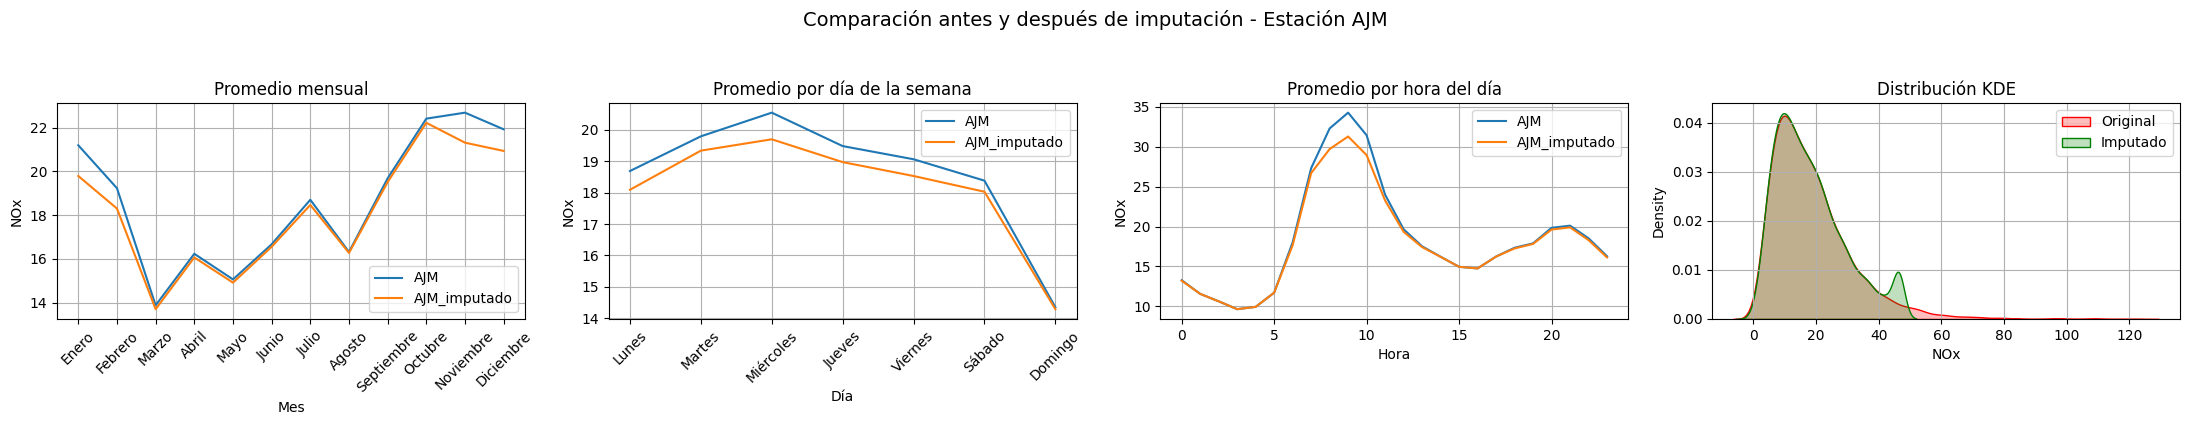


📊 Estación: CCA


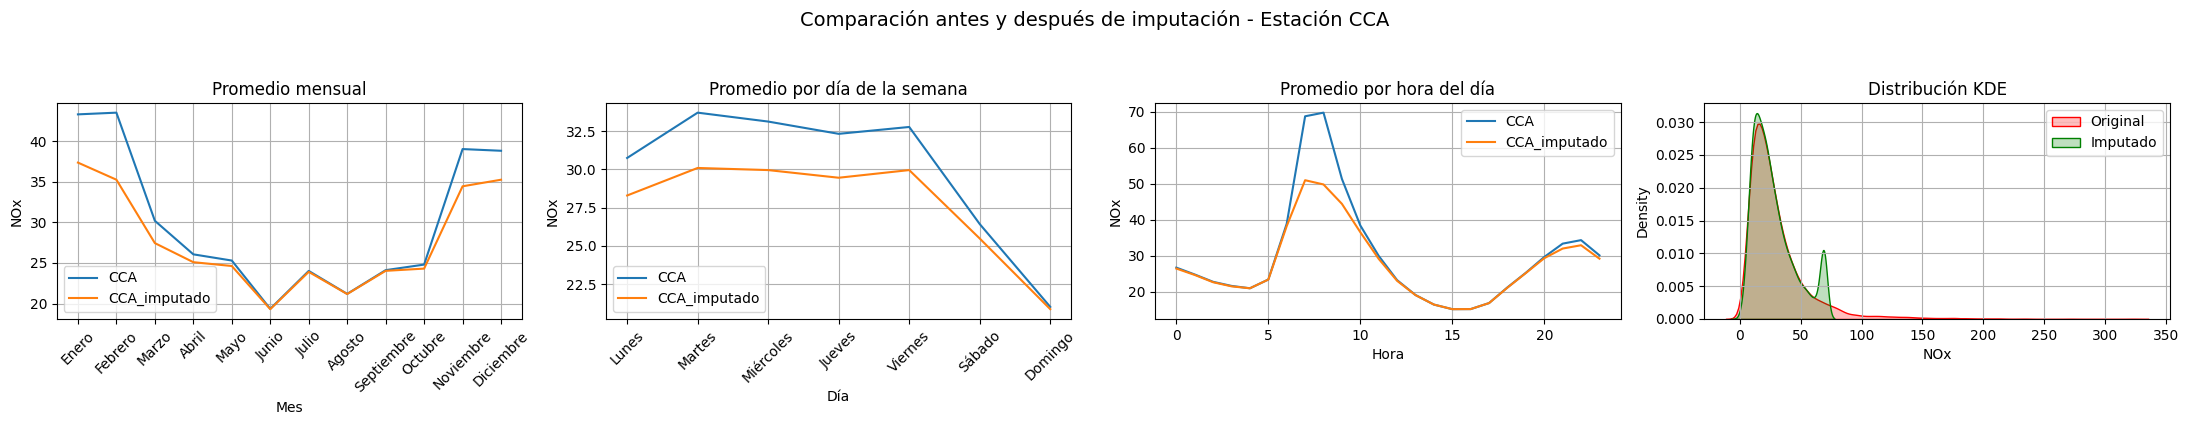


📊 Estación: CUA


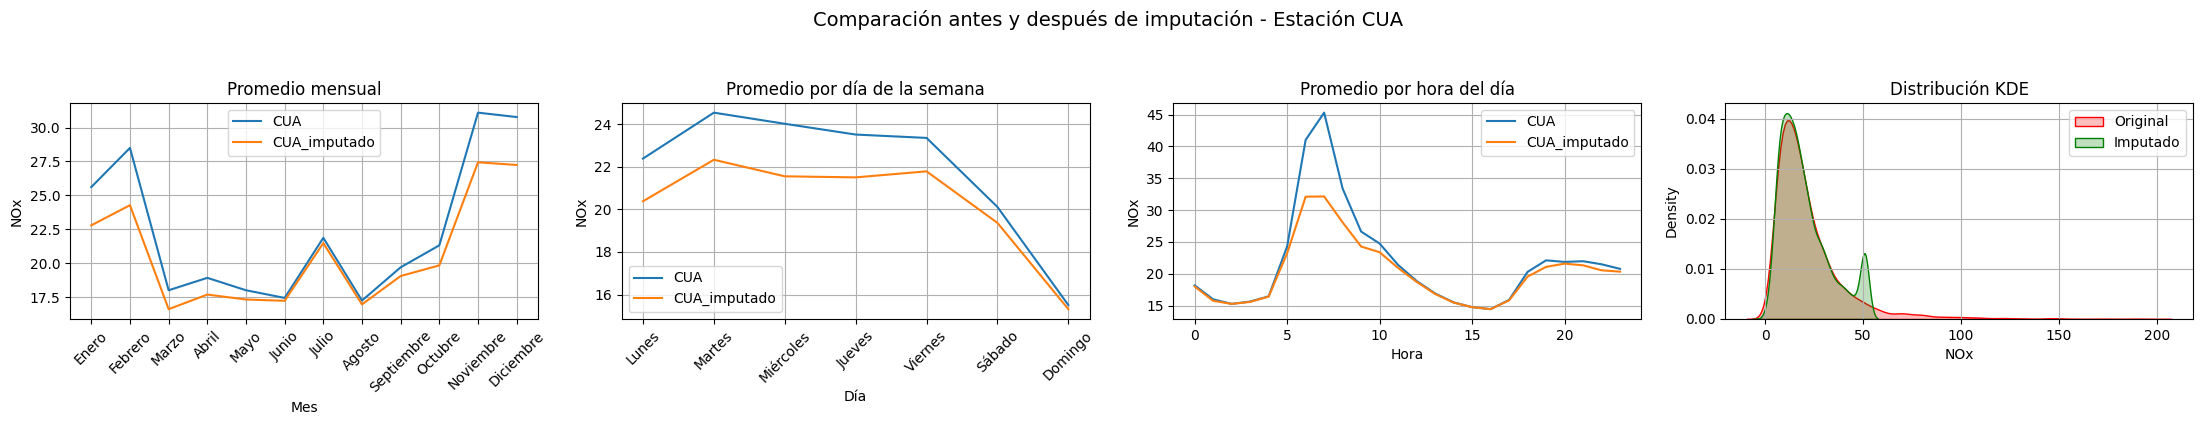


📊 Estación: CUT


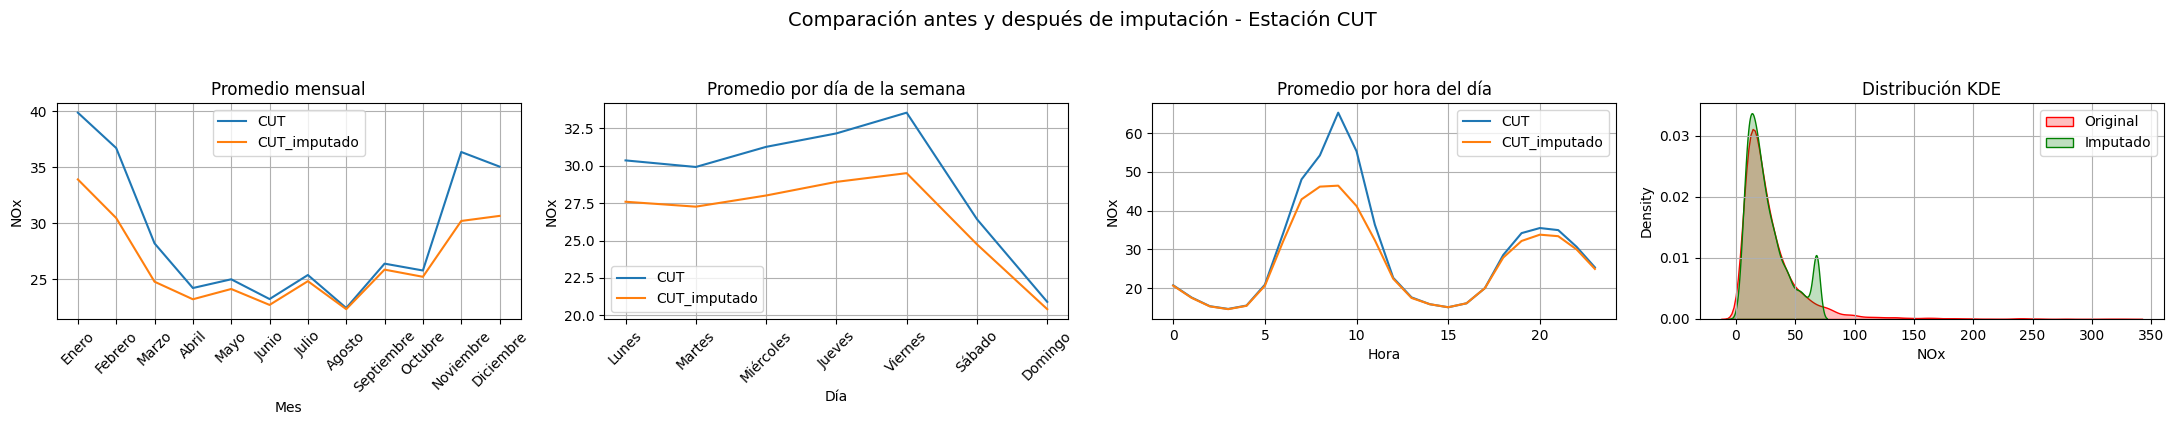


📊 Estación: FAC


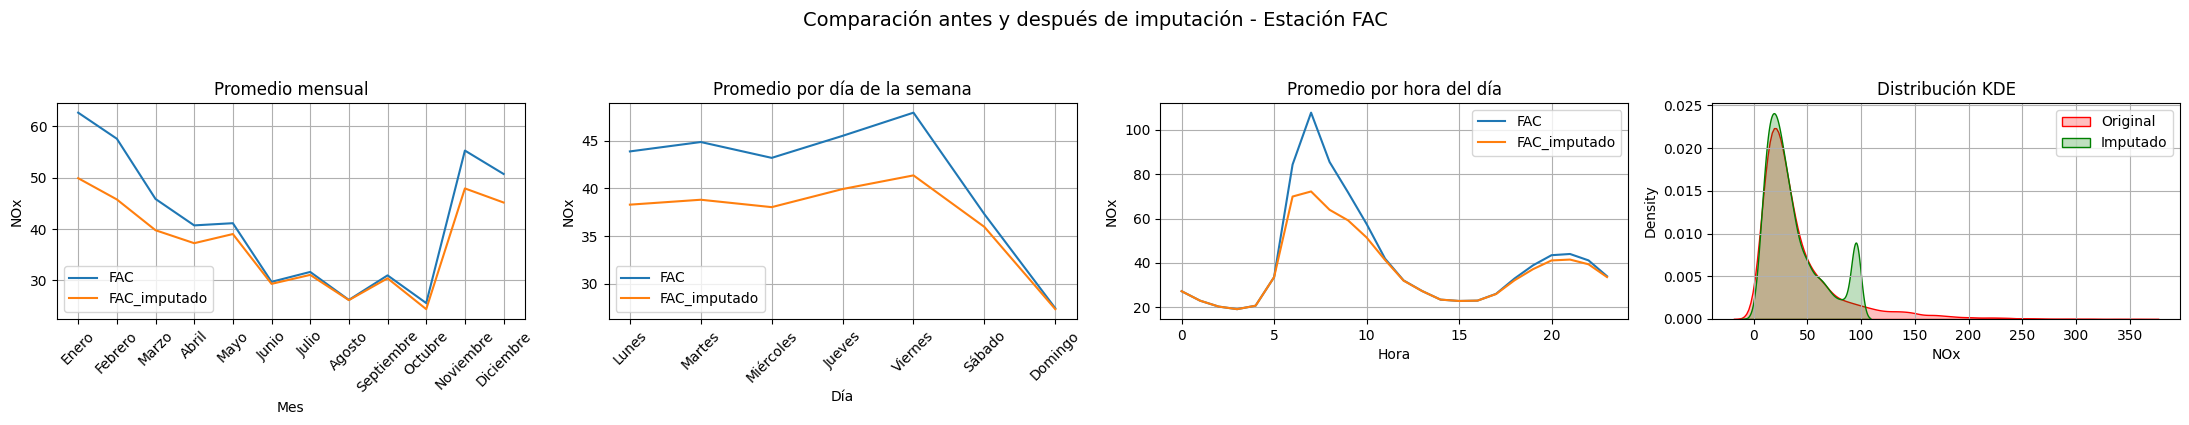


📊 Estación: IZT


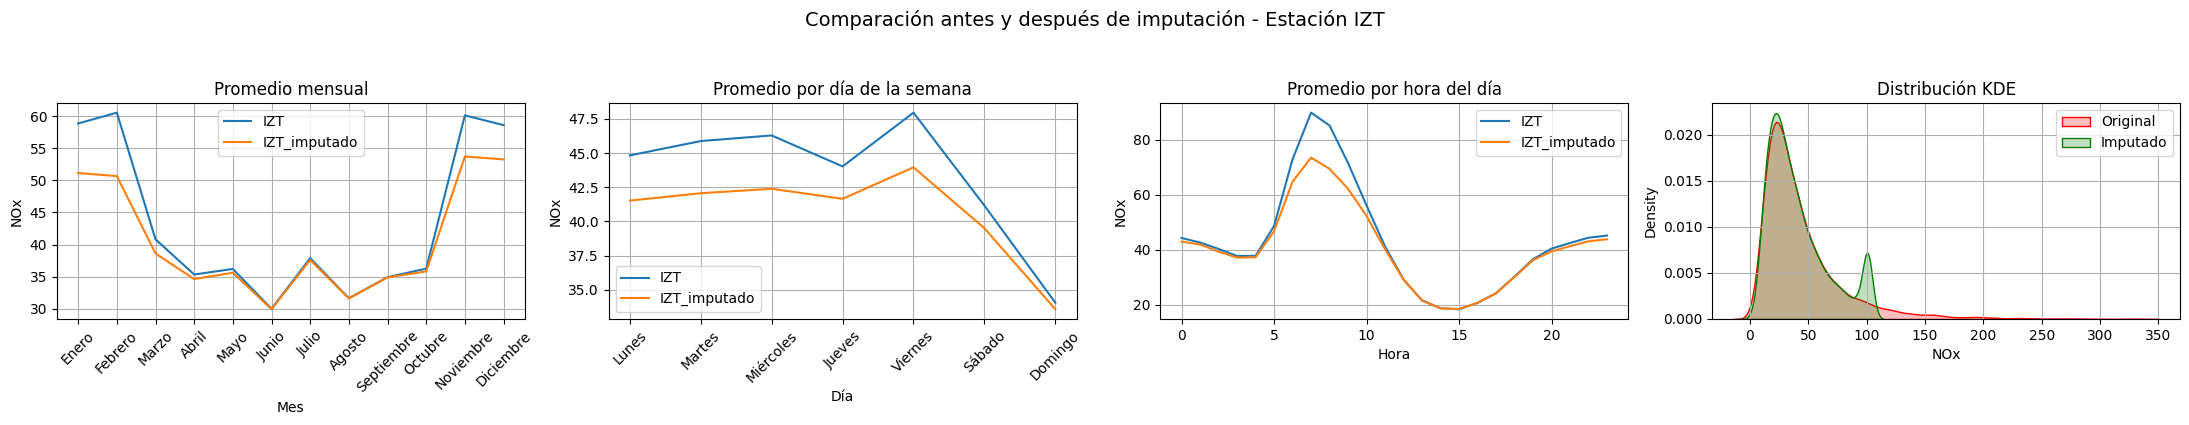


📊 Estación: MER


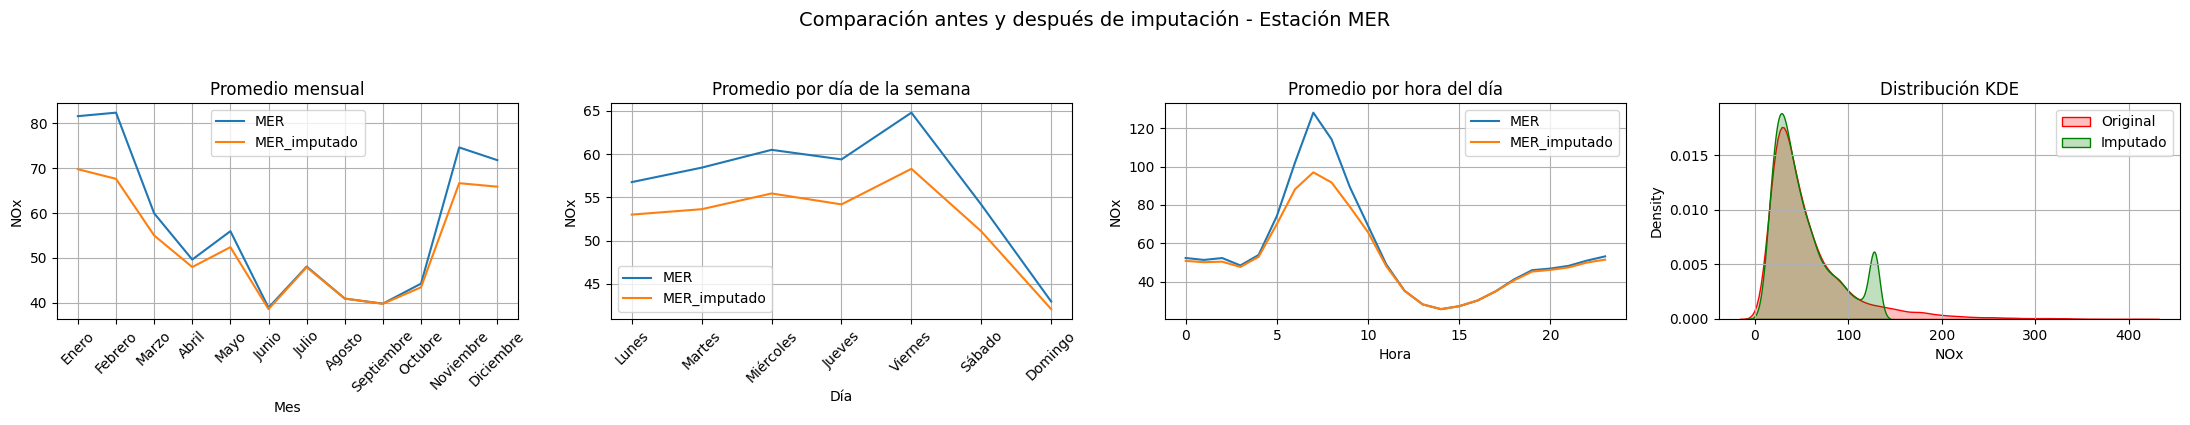


📊 Estación: MGH


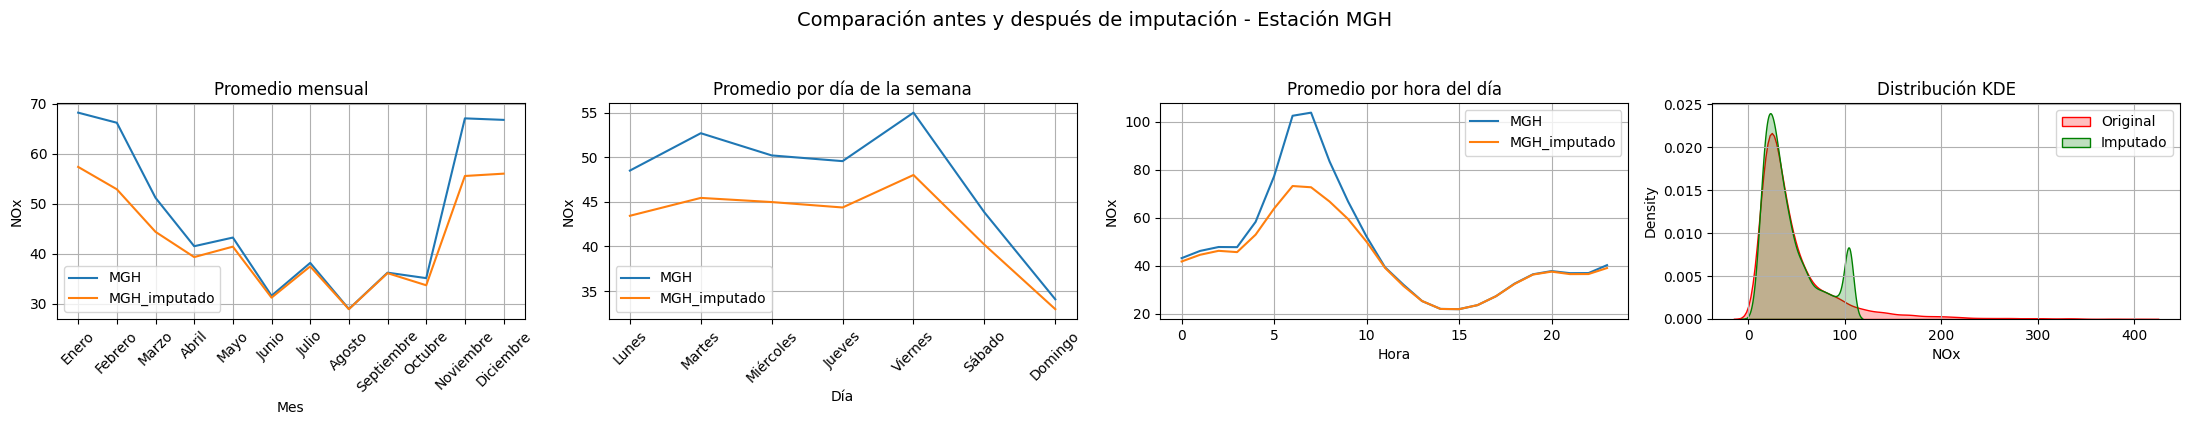


📊 Estación: SAC


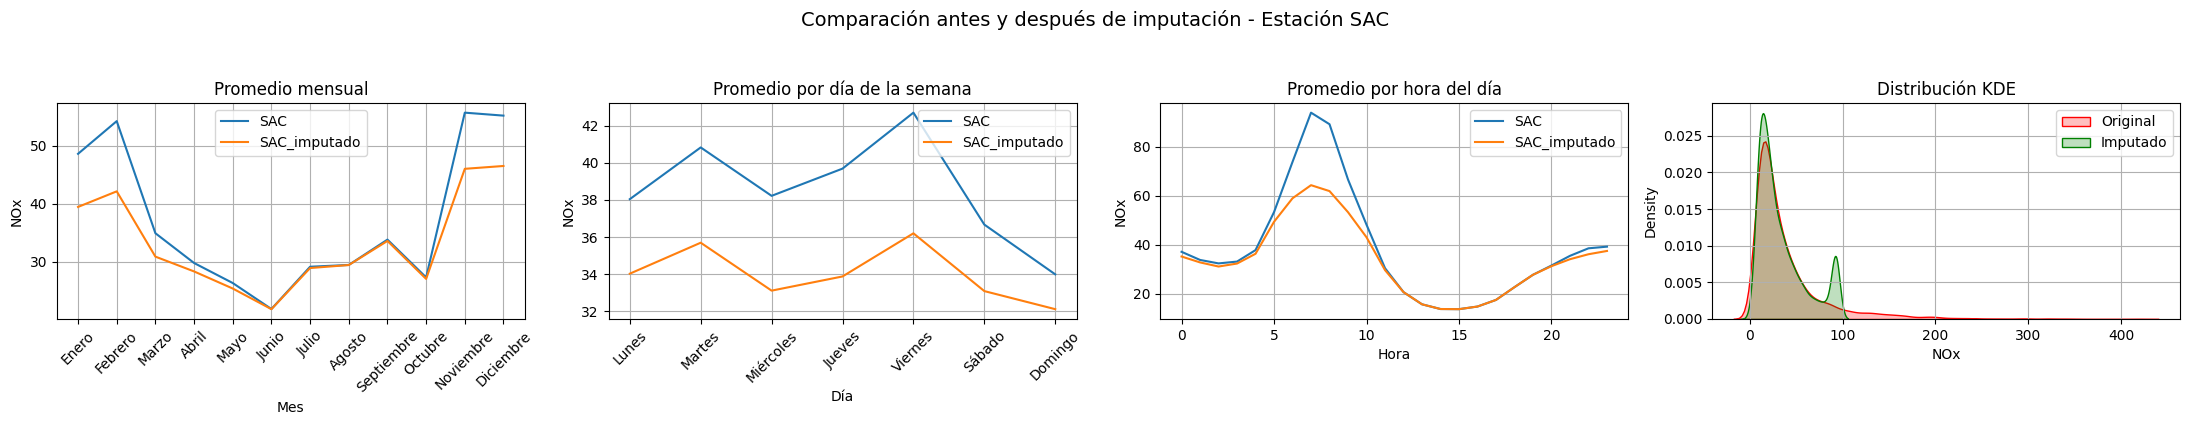


📊 Estación: TLI


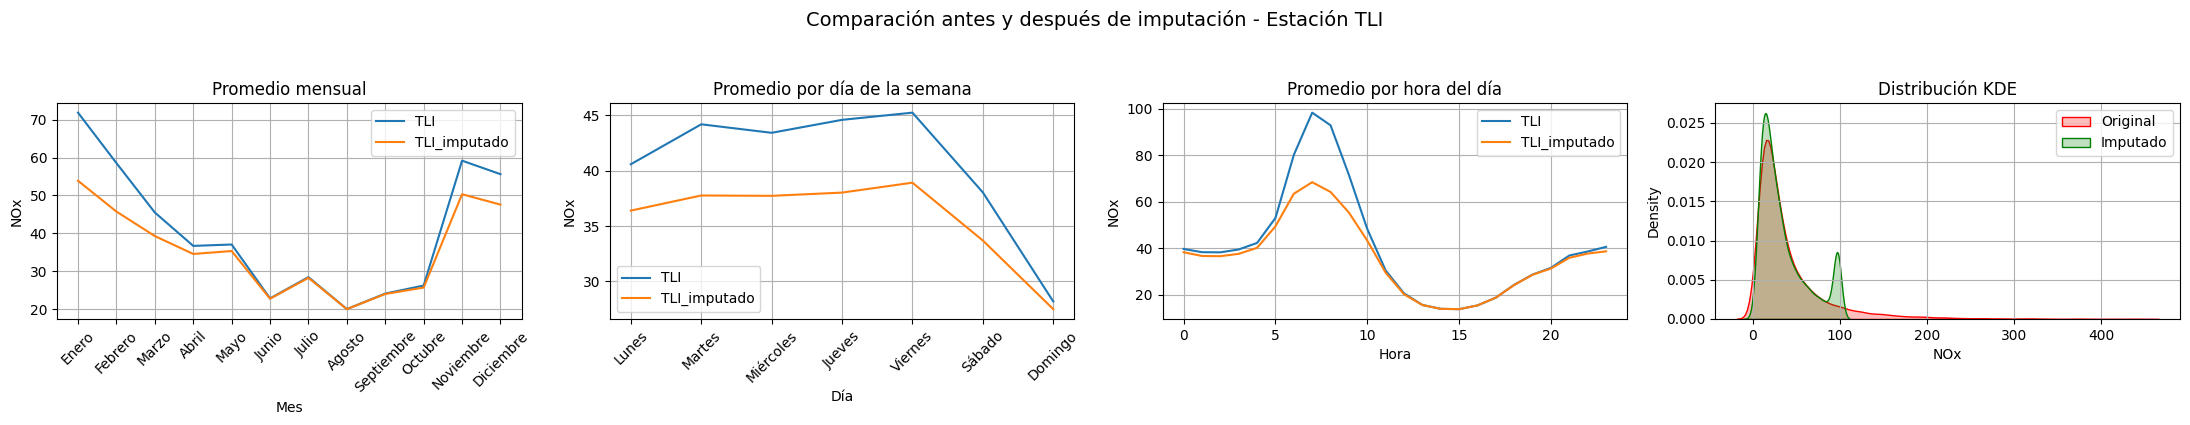


📊 Estación: VIF


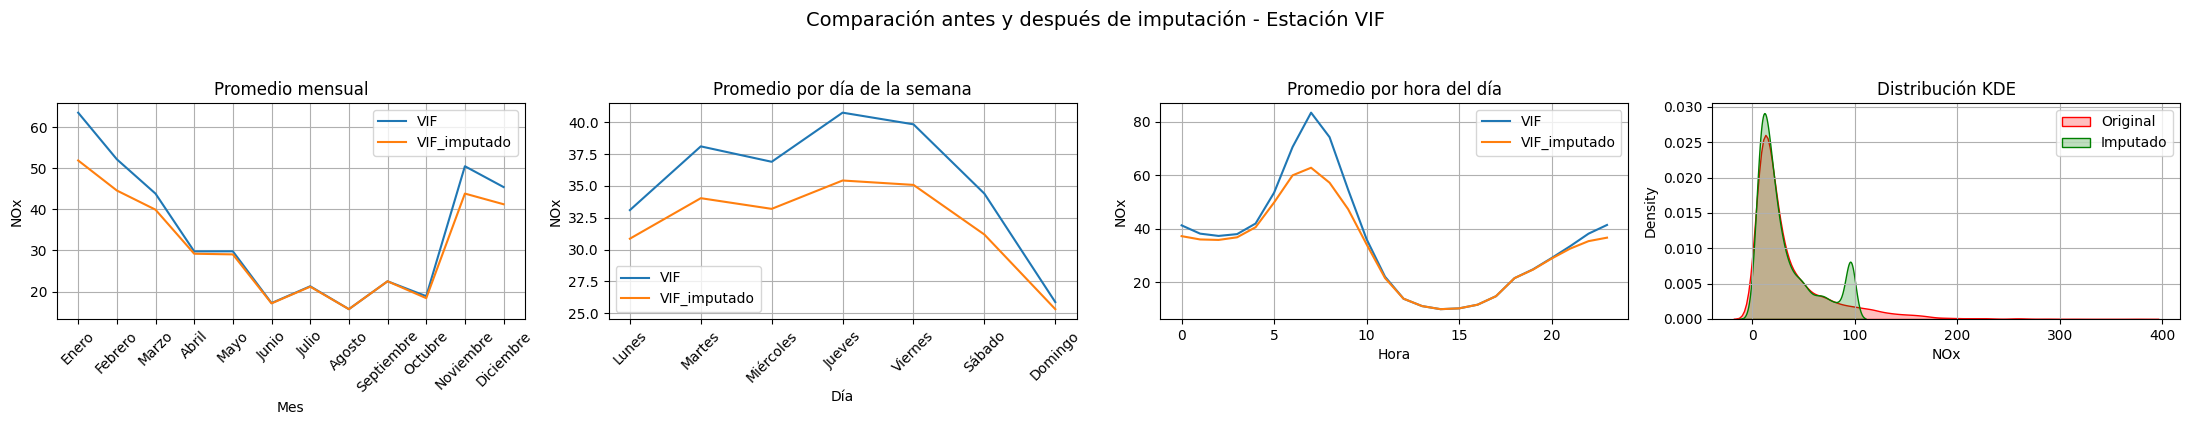

In [23]:
comparar_imputacion_por_estacion(df_2024, df_2024_cappado)

### 🎯 **Hallazgos**  
- **Patrones temporales**:  
  - Los promedios mensuales/horarios se mantienen prácticamente idénticos.    

- **Distribución (KDE)**:  
  - Se reduce el "ruido" en colas extremas sin afectar la moda principal.
 

 
  ## 📌 **Conclusión**  
- La winsorización **no alteró los patrones estacionales** clave para SARIMA.

- **Próximos pasos**:  
  - Imputación de valores faltantes restantes (medias horarias).  
  - Entrenamiento del modelo SARIMA con las series limpias. 

# **Paso 6: Imputación de Datos Faltantes y Diagnóstico de Estacionariedad**  

## 🎯 **Objetivos**  
1. **Completar la serie temporal** de manera inteligente, preservando los patrones horarios y semanales.  
2. **Verificar estacionariedad** (requisito clave para modelos SARIMA) mediante pruebas estadísticas y visualización.  

> **Analogía**:  
> - La imputación es como restaurar un viejo reloj: reemplazamos las piezas faltantes (NaN) con componentes que mantengan su funcionamiento original.  
> - La estacionariedad es como asegurar que el reloj no se acelere ni frene con el tiempo; debe marcar un ritmo constante para que SARIMA pueda predecir la hora futura con precisión.
## **1. Imputación con Media Estacional**
### ¿Por qué no eliminar los NaN?
    El modelo SARIMA es como un músico que lee una partitura. Requiere que el ritmo (la frecuencia de tiempo) sea constante y sin interrupciones.

    Eliminar filas (.dropna()): Esto crea "agujeros" en la serie de tiempo. El modelo pierde la noción del intervalo regular (una hora) y no puede calcular las dependencias estacionales correctamente. 

    Conservar NaNs: El modelo tampoco puede realizar los cálculos matemáticos con valores NaN, por lo que el proceso de entrenamiento fallará.

## **Solución**: Rellenar esos huecos de manera inteligente. Usaremos la  Imputación con la Media Estacional
- Este método es más robusto porque respeta los patrones diarios (la estacionalidad). Por ejemplo, un NaN a las 3 PM se rellena con el promedio de todas las 3 PM del dataset.

In [24]:
def imputar_con_media_estacional(dataframe):
    """
    Rellena valores faltantes usando promedios horarios por día de la semana, 
    garantizando que los patrones diarios/semanales se conserven.

    Pasos:
    1. Fuerza frecuencia horaria (rellena huecos temporales con NaN).  
    2. Calcula medias por hora y día de la semana para cada estación.  
    3. Usa la media global si no hay datos históricos para un slot horario.
    """
    # Indexamos la columna "FECHA_HORA" y usamos .asfreq("h") para completar los registros faltantes
    dataframe = dataframe.set_index("FECHA_HORA").asfreq("h")

    # Recalcular columnas auxiliares después de crear huecos
    dataframe["DÍA_SEMANA"] = dataframe.index.dayofweek
    dataframe["HORA_AJUSTADA"] = dataframe.index.hour
    dataframe["AÑO"] = dataframe.index.year
    dataframe["MES"] = dataframe.index.month

    # Copiamos el dataframe ya reindexado
    df_imputado = dataframe.copy()

    # Columnas auxiliares que no deben imputarse
    columnas_auxiliares = ["AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"]

    # Columnas de estaciones (todas excepto las auxiliares)
    columnas_estaciones = [col for col in df_imputado.columns if col not in columnas_auxiliares]

    # Iteramos sobre cada estación
    for estacion in columnas_estaciones:
        media_estacional = (df_imputado.groupby(["DÍA_SEMANA", "HORA_AJUSTADA"], observed=True)[estacion].transform('mean').round(1))
        df_imputado[estacion] = df_imputado[estacion].fillna(media_estacional).round(1)

        if df_imputado[estacion].isna().any():
            media_global = df_imputado[estacion].mean()
            df_imputado[estacion] = df_imputado[estacion].fillna(media_global)
            print(f"⚠️ Se usó la media global para NaNs restantes en '{estacion}'.")

    return df_imputado

In [25]:
datos_entrenamiento = imputar_con_media_estacional(df_2024_cappado)
datos_entrenamiento

AÑO  MES  DÍA_SEMANA  HORA_AJUSTADA   AJM   CCA   CUA  \
FECHA_HORA                                                                    
2024-01-01 00:00:00  2024    1           0              0  10.0  38.0  17.0   
2024-01-01 01:00:00  2024    1           0              1   9.0  35.0  30.0   
2024-01-01 02:00:00  2024    1           0              2   9.0  54.0  33.0   
2024-01-01 03:00:00  2024    1           0              3   9.0  42.0  28.0   
2024-01-01 04:00:00  2024    1           0              4   7.0  31.0  18.0   
...                   ...  ...         ...            ...   ...   ...   ...   
2024-12-31 19:00:00  2024   12           1             19  20.0  32.0  51.0   
2024-12-31 20:00:00  2024   12           1             20  45.0  20.0  33.0   
2024-12-31 21:00:00  2024   12           1             21  34.0  37.0  26.0   
2024-12-31 22:00:00  2024   12           1             22  16.0  39.0  28.0   
2024-12-31 23:00:00  2024   12           1             23  11.0  29.0  25.0   

                      CUT   FAC   IZT    MER   MGH   SAC   TLI   VIF  
FECHA_HORA                                                            
2024-01-01 00:00:00  31.0  32.0  59.0   70.0  29.0  66.0  54.0  70.0  
2024-01-01 01:00:00  36.0  68.0  70.0   92.0  78.0  76.0  54.0  91.0  
2024-01-01 02:00:00  28.0  66.0  71.0  128.0  67.0  92.8  83.0  96.0  
2024-01-01 03:00:00  20.0  46.0  81.0  108.0  68.0  92.8  70.0  81.0  
2024-01-01 04:00:00  19.0  35.0  69.0   87.0  61.0  89.0  68.0  81.0  
...                   ...   ...   ...    ...   ...   ...   ...   ...  
2024-12-31 19:00:00  45.0  38.0  66.0   50.0  44.0  43.0  28.0  21.0  
2024-12-31 20:00:00  39.0  39.0  37.0   44.4  43.0  46.0  30.0  26.0  
2024-12-31 21:00:00  43.0  47.0  30.0   47.6  36.0  42.0  36.0  33.0  
2024-12-31 22:00:00  45.0  27.0  44.0   51.0  29.0  50.0  57.0  52.0  
2024-12-31 23:00:00  37.0  20.0  36.0   53.0  21.0  74.0  51.0  73.0  

[8784 rows x 15 columns]

In [26]:
porcentaje_completitud(datos_entrenamiento,8784)

Estacion  % datos
0       AJM    100.0
1       CCA    100.0
2       CUA    100.0
3       CUT    100.0
4       FAC    100.0
5       IZT    100.0
6       MER    100.0
7       MGH    100.0
8       SAC    100.0
9       TLI    100.0
10      VIF    100.0

### ✅ **Resultados**  
- **Completitud del 100%**: Todas las estaciones ahora tienen datos completos (verificado con `porcentaje_completitud`).  
- **Patrones preservados**:  
  - La variación horaria (ej. picos matutinos) se mantiene intacta.  
  - No se introducen saltos artificiales en la serie.  

## **2. Diagnóstico de Estacionariedad**  

### 📊 **¿Qué es la estacionariedad?**  
Una serie es estacionaria si:  
- **Media constante**: No tiene tendencia ascendente/descendente.  
- **Varianza constante**: La dispersión no cambia con el tiempo.  
- **Autocorrelación estable**: Los patrones se repiten en intervalos fijos. 

In [27]:
datos_entrenamiento = datos_entrenamiento.drop(["AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"], axis= 1)
datos_entrenamiento

AJM   CCA   CUA   CUT   FAC   IZT    MER   MGH   SAC  \
FECHA_HORA                                                                   
2024-01-01 00:00:00  10.0  38.0  17.0  31.0  32.0  59.0   70.0  29.0  66.0   
2024-01-01 01:00:00   9.0  35.0  30.0  36.0  68.0  70.0   92.0  78.0  76.0   
2024-01-01 02:00:00   9.0  54.0  33.0  28.0  66.0  71.0  128.0  67.0  92.8   
2024-01-01 03:00:00   9.0  42.0  28.0  20.0  46.0  81.0  108.0  68.0  92.8   
2024-01-01 04:00:00   7.0  31.0  18.0  19.0  35.0  69.0   87.0  61.0  89.0   
...                   ...   ...   ...   ...   ...   ...    ...   ...   ...   
2024-12-31 19:00:00  20.0  32.0  51.0  45.0  38.0  66.0   50.0  44.0  43.0   
2024-12-31 20:00:00  45.0  20.0  33.0  39.0  39.0  37.0   44.4  43.0  46.0   
2024-12-31 21:00:00  34.0  37.0  26.0  43.0  47.0  30.0   47.6  36.0  42.0   
2024-12-31 22:00:00  16.0  39.0  28.0  45.0  27.0  44.0   51.0  29.0  50.0   
2024-12-31 23:00:00  11.0  29.0  25.0  37.0  20.0  36.0   53.0  21.0  74.0   

                      TLI   VIF  
FECHA_HORA                       
2024-01-01 00:00:00  54.0  70.0  
2024-01-01 01:00:00  54.0  91.0  
2024-01-01 02:00:00  83.0  96.0  
2024-01-01 03:00:00  70.0  81.0  
2024-01-01 04:00:00  68.0  81.0  
...                   ...   ...  
2024-12-31 19:00:00  28.0  21.0  
2024-12-31 20:00:00  30.0  26.0  
2024-12-31 21:00:00  36.0  33.0  
2024-12-31 22:00:00  57.0  52.0  
2024-12-31 23:00:00  51.0  73.0  

[8784 rows x 11 columns]

In [28]:
from statsmodels.tsa.stattools import adfuller

def diagnostico_estacionariedad(dataframe):
    """
    Evalúa estacionariedad para cada estación usando:
    1. **Prueba ADF (Augmented Dickey-Fuller)**: 
       - Hipótesis nula (H₀): La serie NO es estacionaria.  
       - Si p-value < 0.05, rechazamos H₀ (✅ estacionaria).  
    2. **Gráficas comparativas**:  
       - Serie original vs. diferenciada (para identificar tendencias).  
    """
    
    for estacion in dataframe.columns:
        serie = dataframe[estacion]

        # ADF test original
        adf_orig = adfuller(serie.dropna())
        pval_orig = adf_orig[1]

        # Diferenciación simple
        serie_diff = serie.diff().dropna()
        adf_diff = adfuller(serie_diff)
        pval_diff = adf_diff[1]

        # Gráficas en un renglón
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        axes[0].plot(serie, label='Original')
        axes[0].set_title(f'{estacion} - Original')
        axes[0].legend()

        axes[1].plot(serie_diff, label='Diferenciada (d=1)', color='orange')
        axes[1].set_title(f'{estacion} - Diferenciada')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

        # Resultados ADF
        print(f'📍 Estación: {estacion}')
        print(f'  [Original]     ADF: {adf_orig[0]:.2f} | p-value: {pval_orig:.4g}')
        print(f'  [Diferenciada] ADF: {adf_diff[0]:.2f} | p-value: {pval_diff:.4g}')
        print('  → Estacionaria:', '✅' if pval_orig < 0.05 else '❌ (requiere d=1)')
        print('-' * 50)


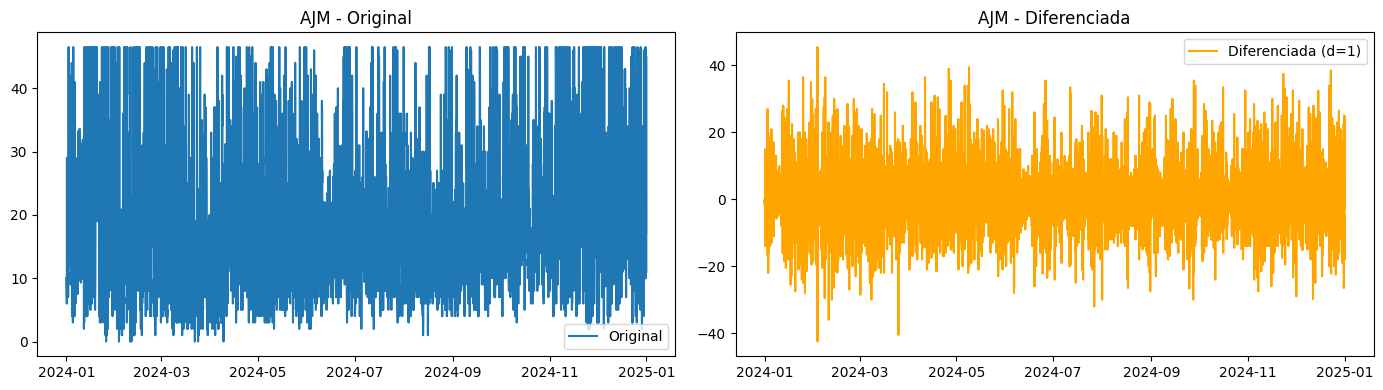

📍 Estación: AJM
  [Original]     ADF: -11.39 | p-value: 8.309e-21
  [Diferenciada] ADF: -23.64 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


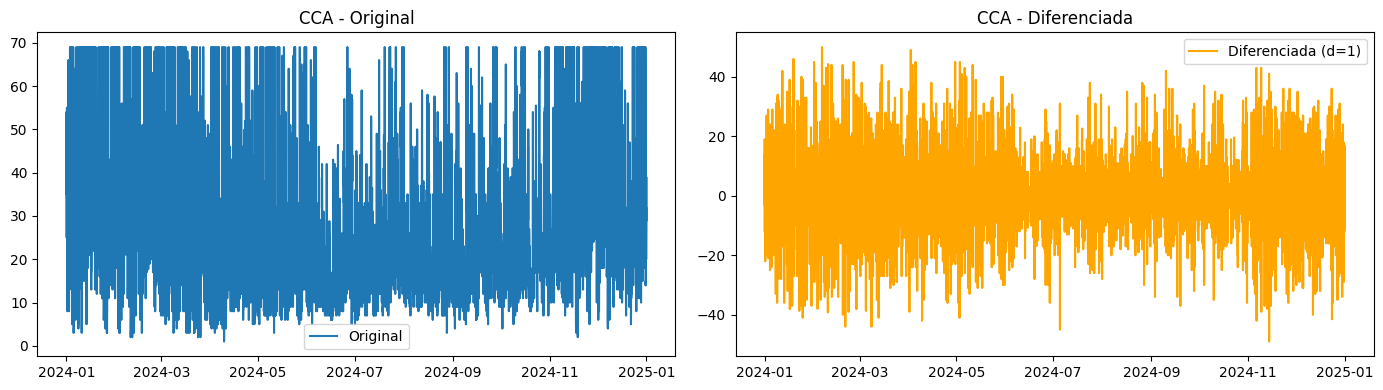

📍 Estación: CCA
  [Original]     ADF: -9.84 | p-value: 4.753e-17
  [Diferenciada] ADF: -20.67 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


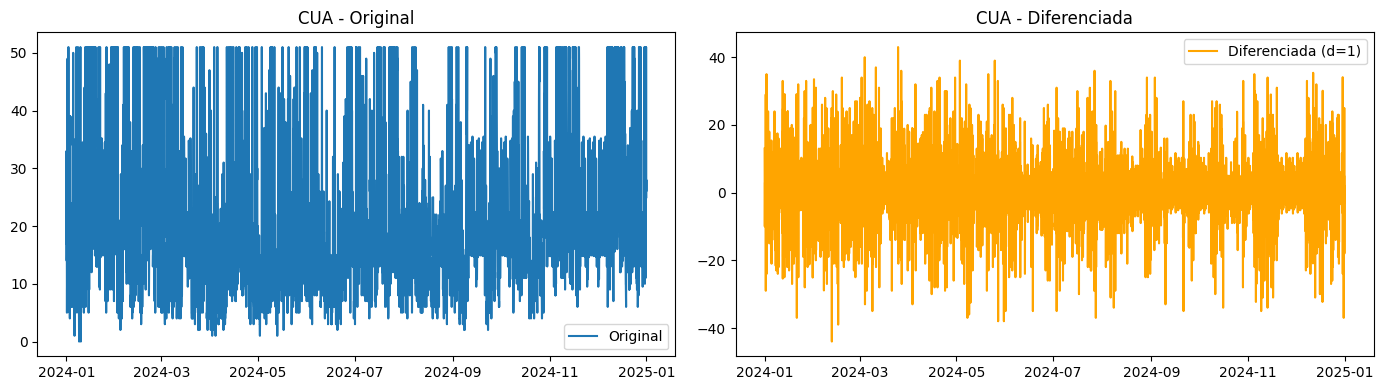

📍 Estación: CUA
  [Original]     ADF: -11.34 | p-value: 1.073e-20
  [Diferenciada] ADF: -20.57 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


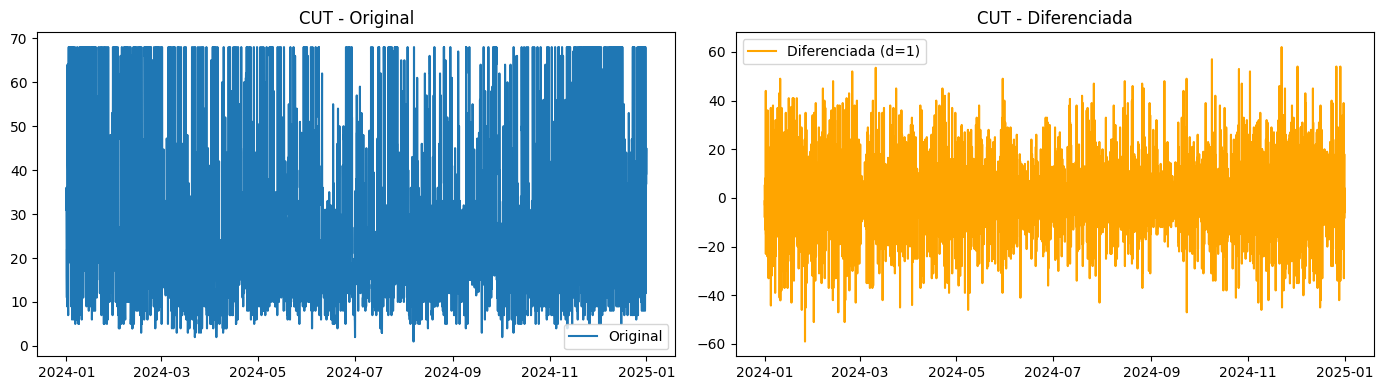

📍 Estación: CUT
  [Original]     ADF: -11.75 | p-value: 1.191e-21
  [Diferenciada] ADF: -25.50 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


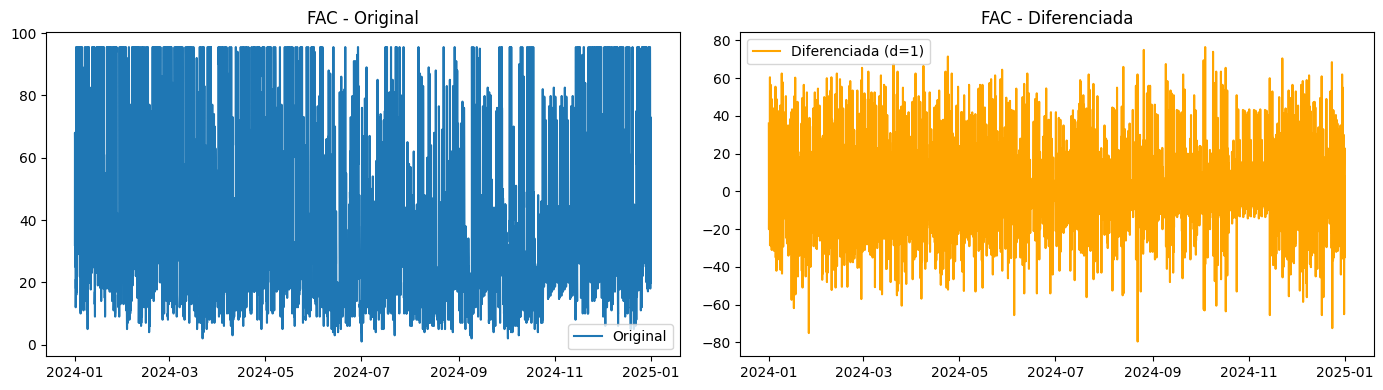

📍 Estación: FAC
  [Original]     ADF: -11.06 | p-value: 4.776e-20
  [Diferenciada] ADF: -24.16 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


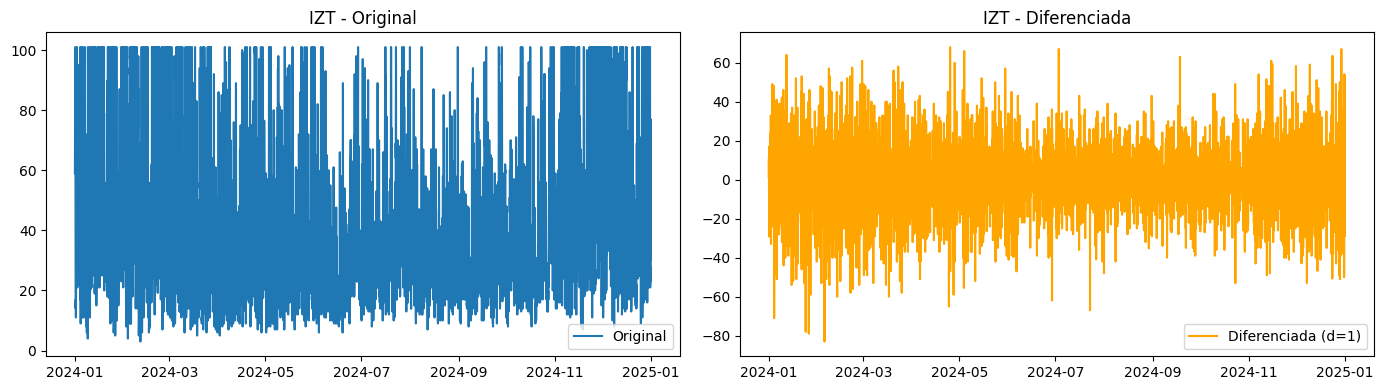

📍 Estación: IZT
  [Original]     ADF: -9.54 | p-value: 2.789e-16
  [Diferenciada] ADF: -25.39 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


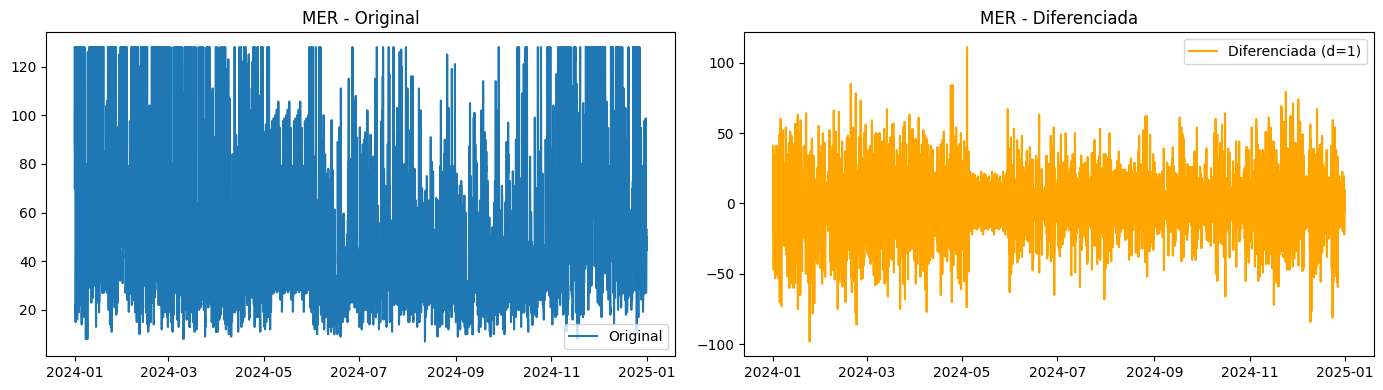

📍 Estación: MER
  [Original]     ADF: -10.07 | p-value: 1.298e-17
  [Diferenciada] ADF: -19.90 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


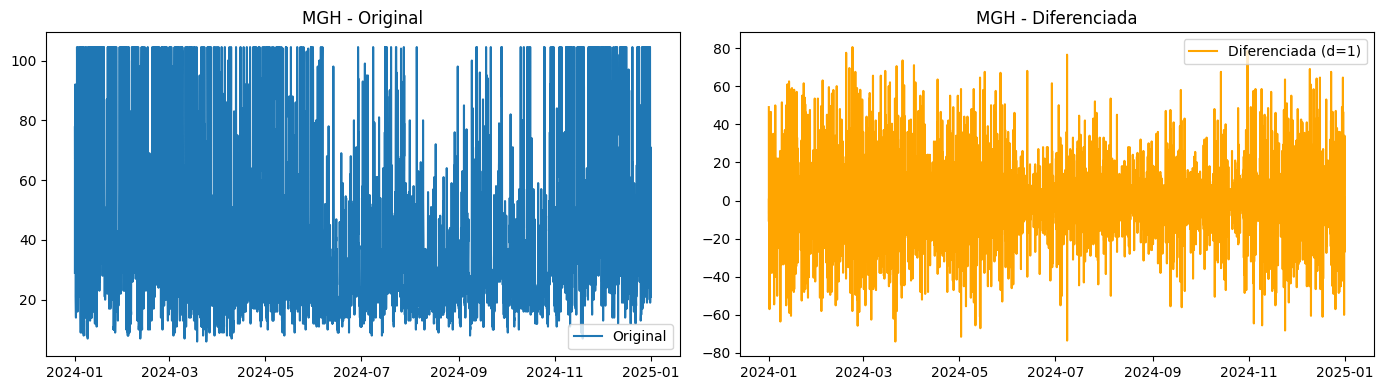

📍 Estación: MGH
  [Original]     ADF: -10.27 | p-value: 3.942e-18
  [Diferenciada] ADF: -25.18 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


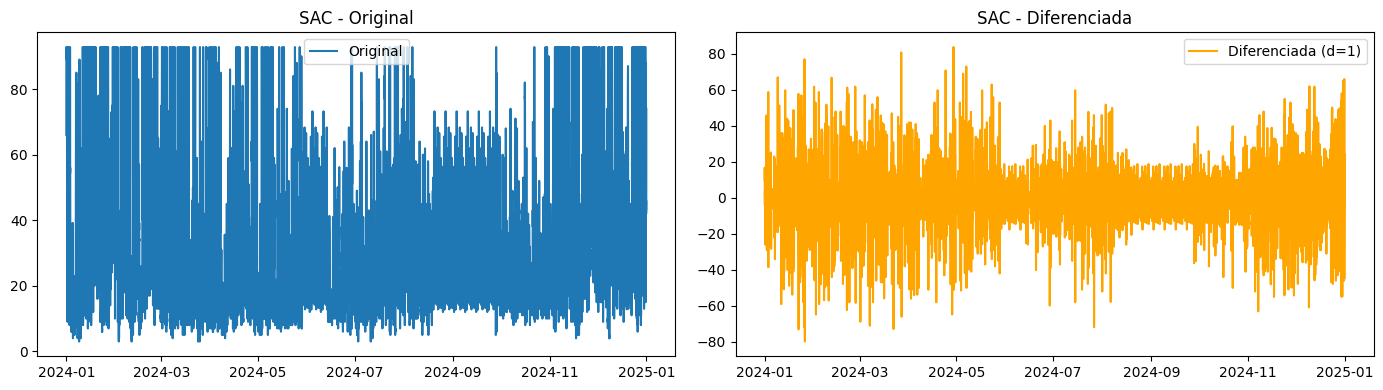

📍 Estación: SAC
  [Original]     ADF: -8.87 | p-value: 1.434e-14
  [Diferenciada] ADF: -28.24 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


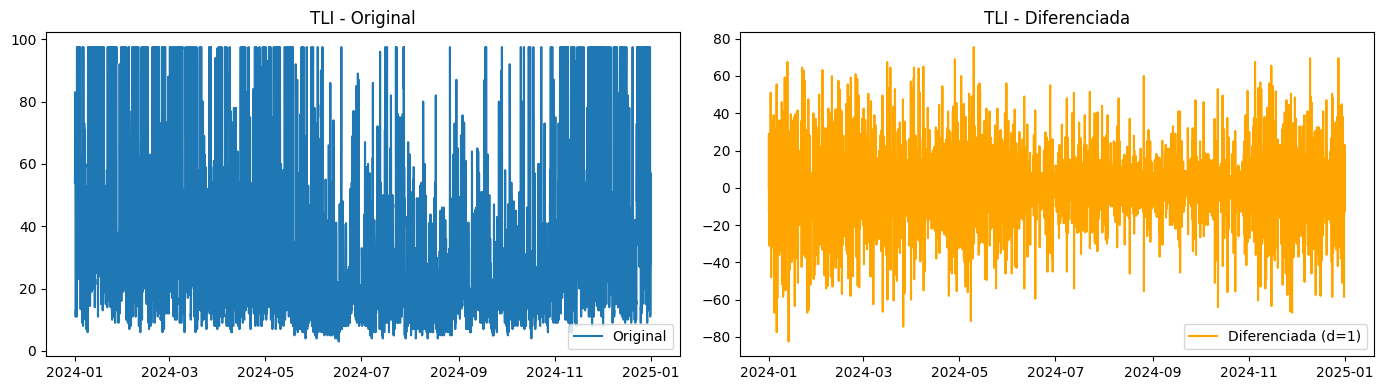

📍 Estación: TLI
  [Original]     ADF: -9.01 | p-value: 6.192e-15
  [Diferenciada] ADF: -24.91 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


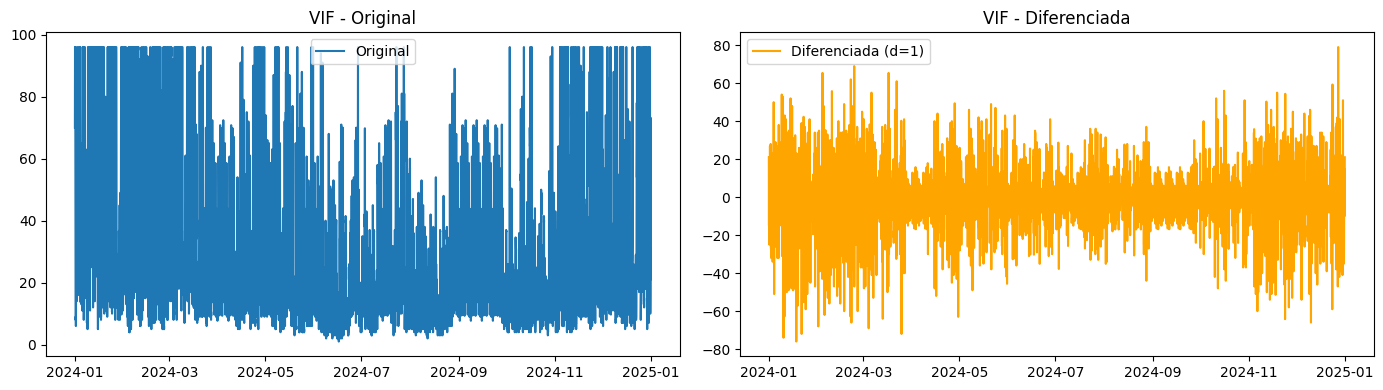

📍 Estación: VIF
  [Original]     ADF: -8.44 | p-value: 1.76e-13
  [Diferenciada] ADF: -25.47 | p-value: 0
  → Estacionaria: ✅
--------------------------------------------------


In [29]:
diagnostico_estacionariedad(datos_entrenamiento)

### 📌 **Resultados del Test ADF** 
**Interpretación**:  
- **Todos los p-values ≈ 0** (< 0.05): Las series **son estacionarias** sin necesidad de diferenciación.  
- **Gráficas**:  
  - **Original (azul)**: Sin tendencias obvias; fluctuaciones alrededor de una media estable.  
  - **Diferenciada (naranja)**: Ruido blanco (confirmando estacionariedad).  

### 🎯 **Implicaciones para SARIMA**  
- **Parámetro `d=0`**: No se requiere diferenciación (las series ya son estacionarias).  
- **Siguientes pasos**:  
  - Ajustar componentes estacionales (`S=24` para patrones horarios).  
  - Optimizar `p` (AR) y `q` (MA) con ACF/PACF.  

# **Paso 7: Análisis de Correlogramas (ACF/PACF)**  
## 🎯 **Correlogramas ¿Por qué analizar ACF/PACF tras la imputación?**  

La imputación no solo rellena huecos, sino que debe **preservar la estructura temporal original**. Los correlogramas nos permiten verificar:

Las gráficas de **correlación con rezagos (ACF)** y **correlación parcial (PACF)** nos permiten responder:

- **¿Se conservaron los patrones de dependencia temporal?**
- **¿Sigue existiendo estacionalidad diaria o semanal?**
- **¿Podemos aplicar modelos como SARIMA sin distorsionar la dinámica original?**

---


In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def graficar_acf_pacf(dataframe, lags):
    """
    Genera gráficos ACF y PACF para diagnosticar:
    - Autocorrelación (dependencia con valores pasados)
    - Estacionalidad (patrones cíclicos)
    
    Parámetros:
        dataframe (pd.DataFrame): Datos post-imputación
        lags (int): Número de retrasos analizados (ej. 168 = 1 semana)
    """
    for estacion in dataframe.columns:
        serie = dataframe[estacion].dropna()

        fig, axes = plt.subplots(1, 2, figsize=(20, 4))
        plt.grid(True)
        plot_acf(serie, ax=axes[0], lags=lags)
        axes[0].set_title(f'{estacion} - ACF')

        plot_pacf(serie, ax=axes[1], lags=lags, method='ywm')
        axes[1].set_title(f'{estacion} - PACF')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        

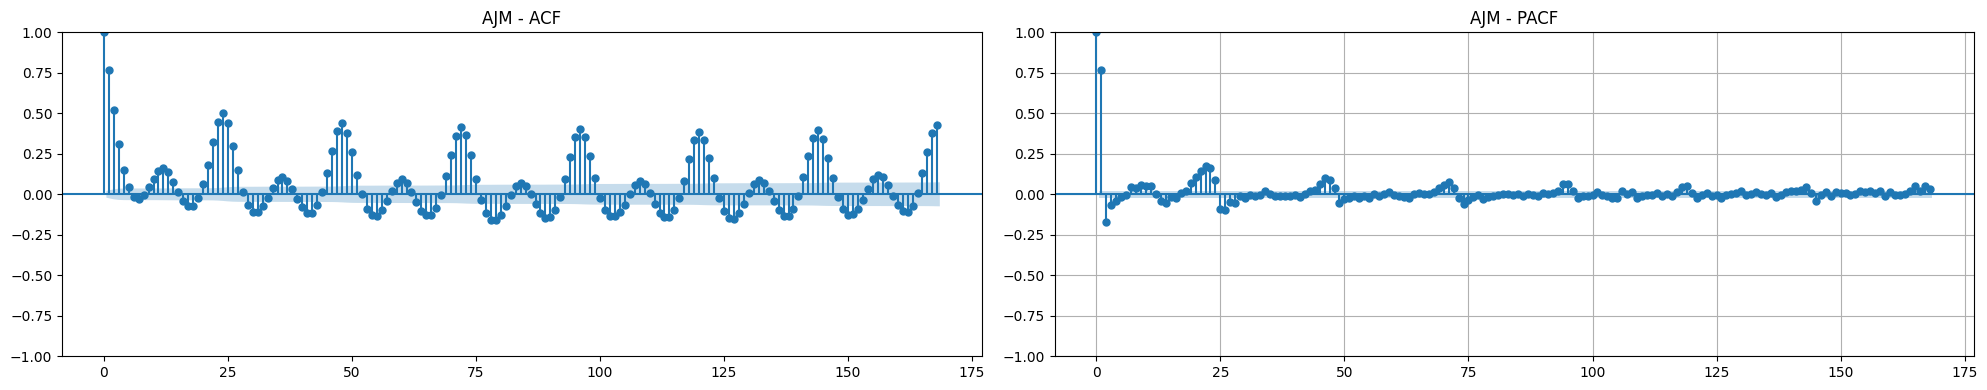

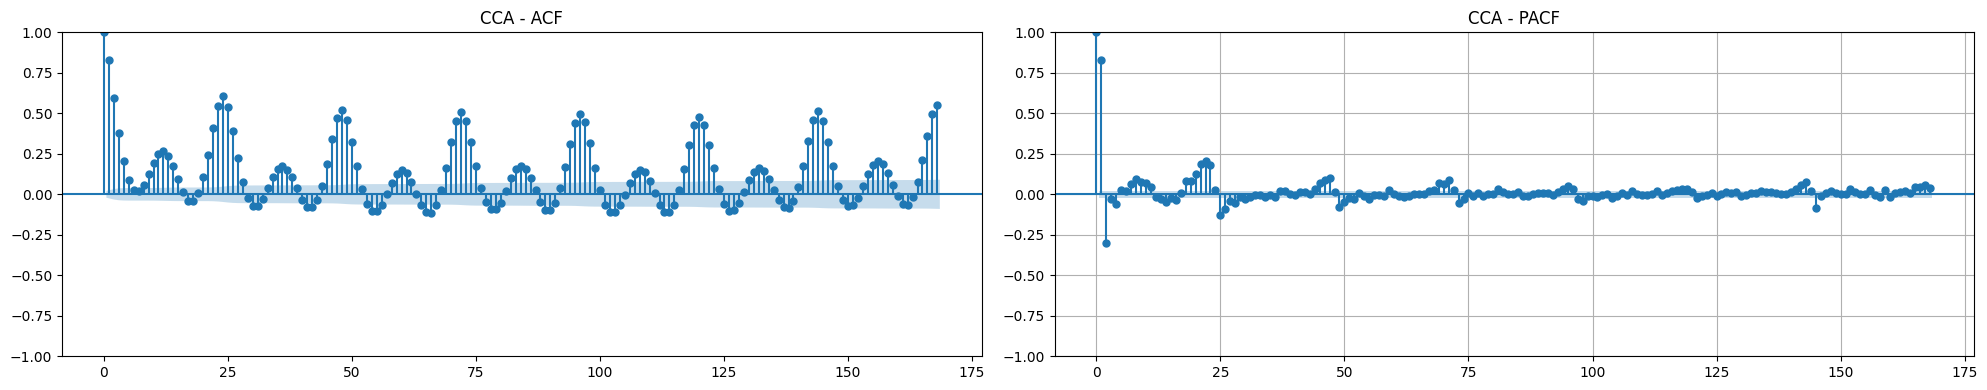

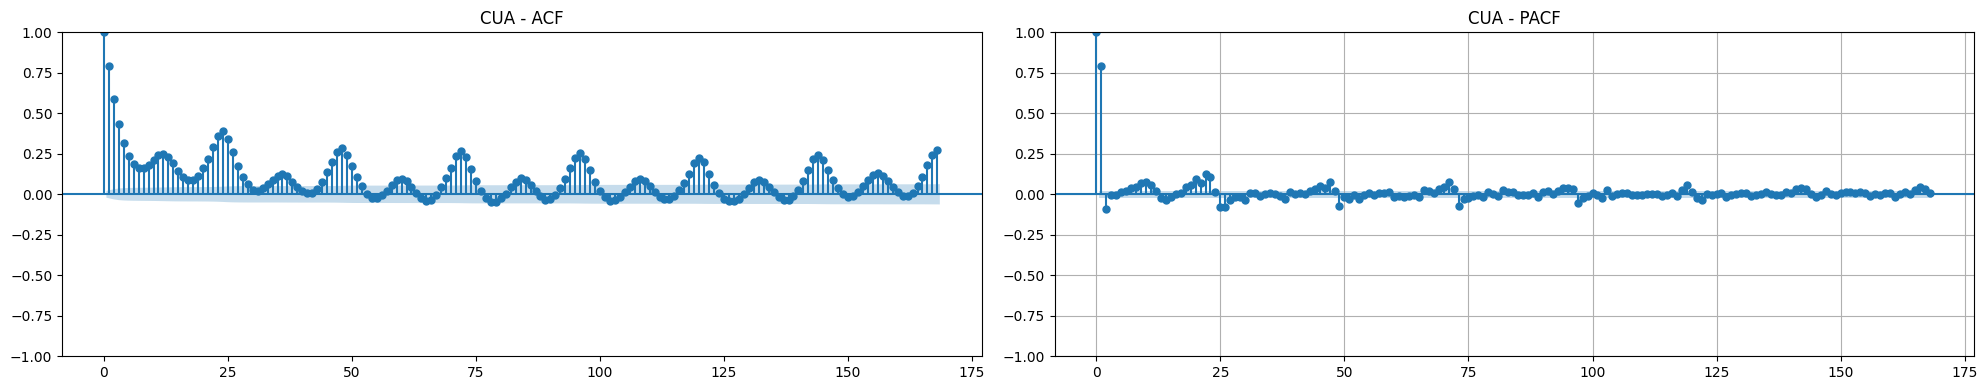

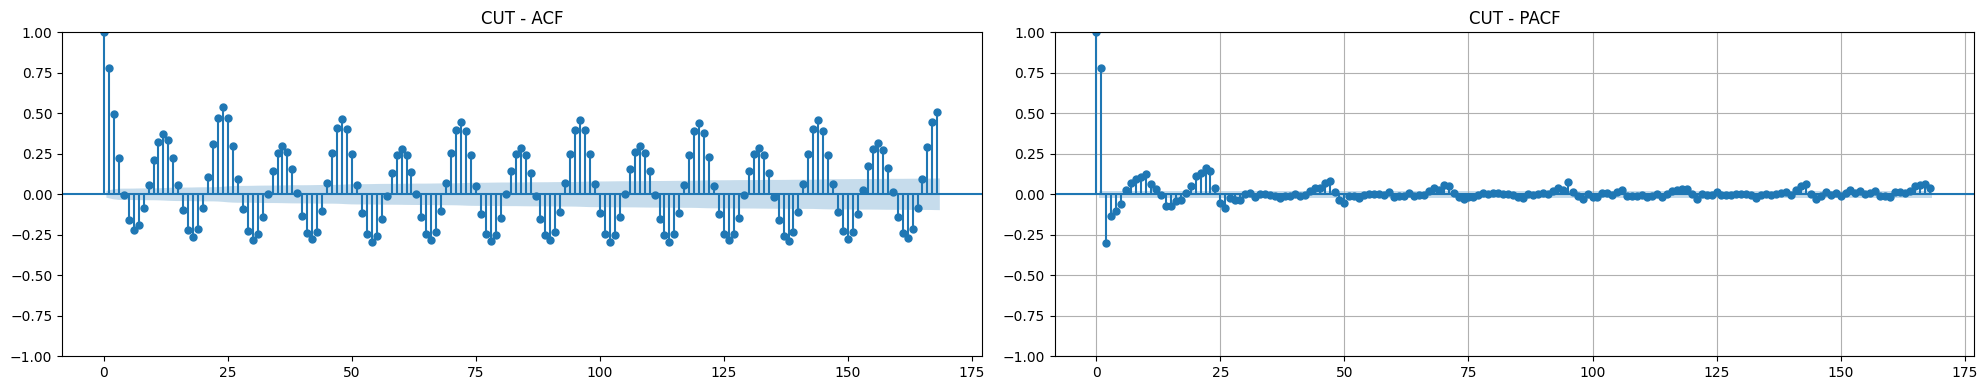

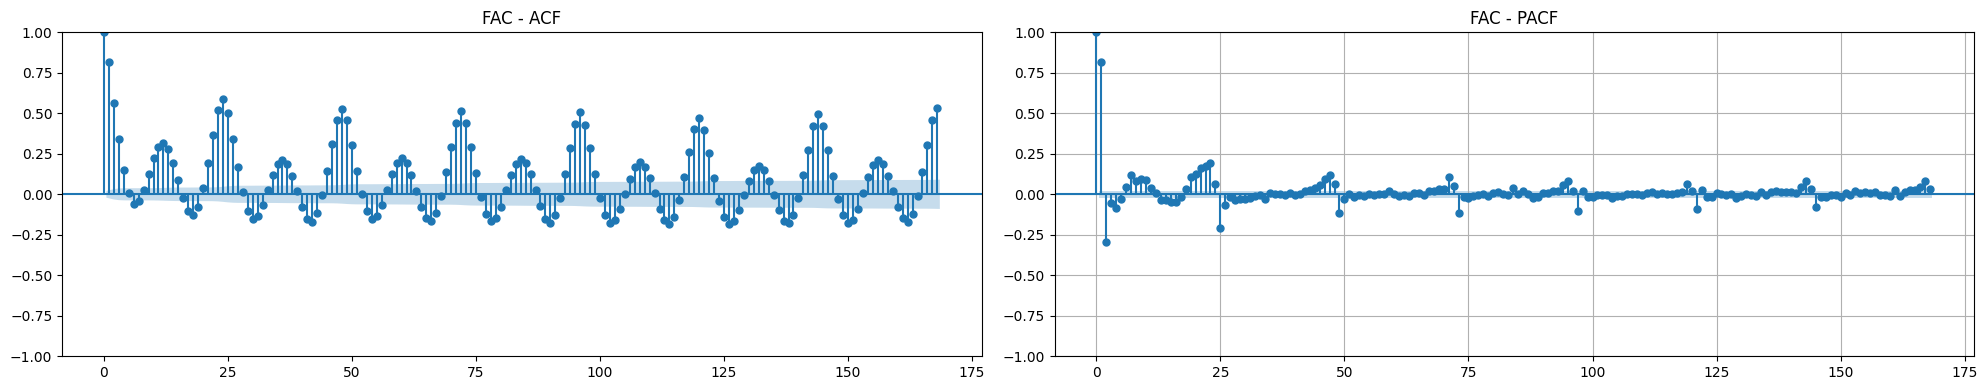

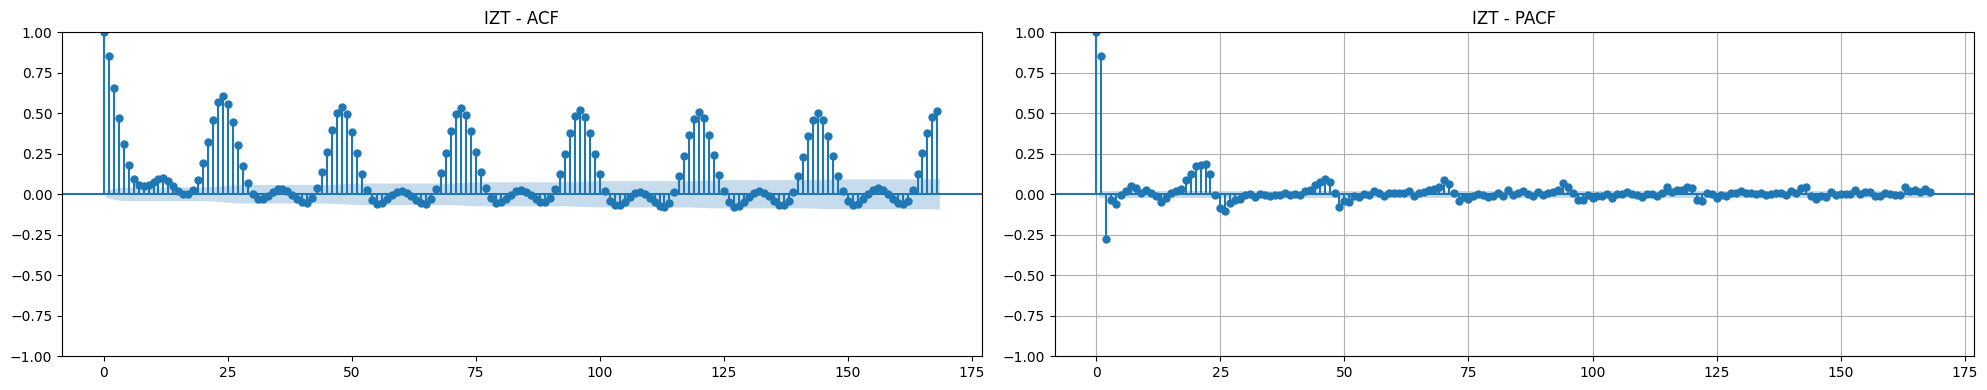

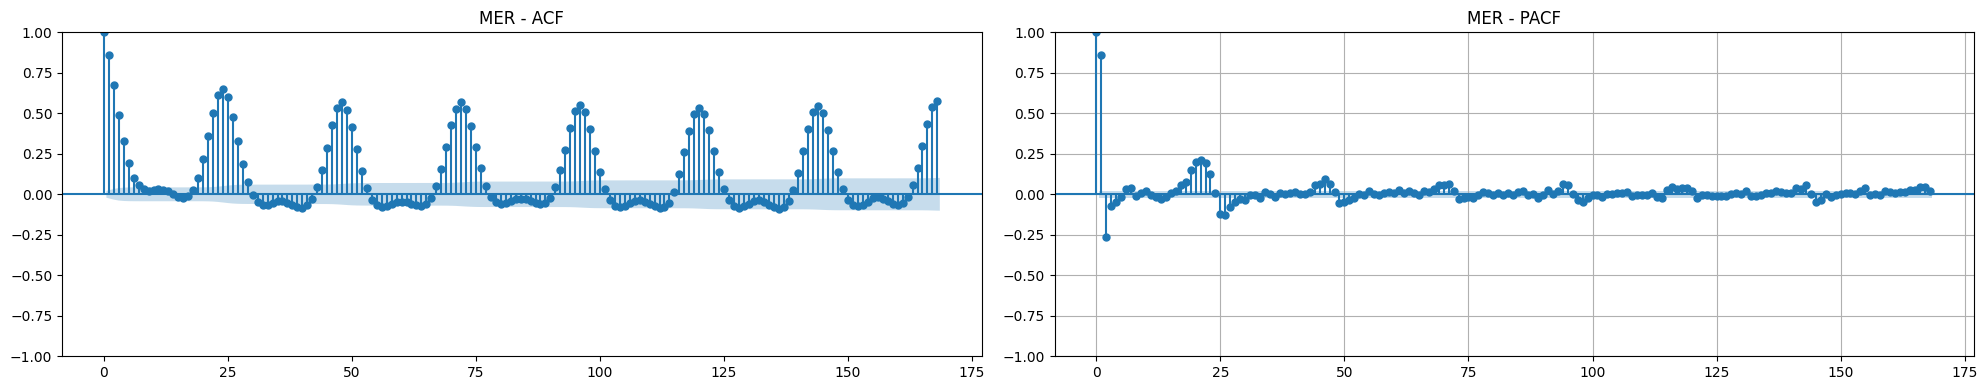

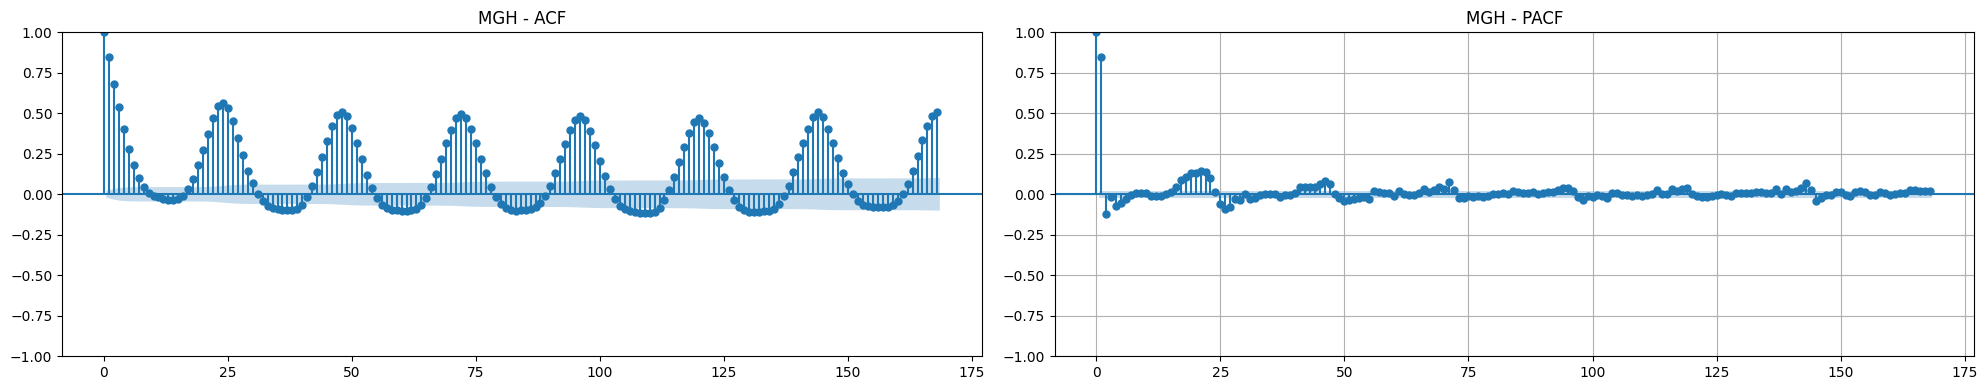

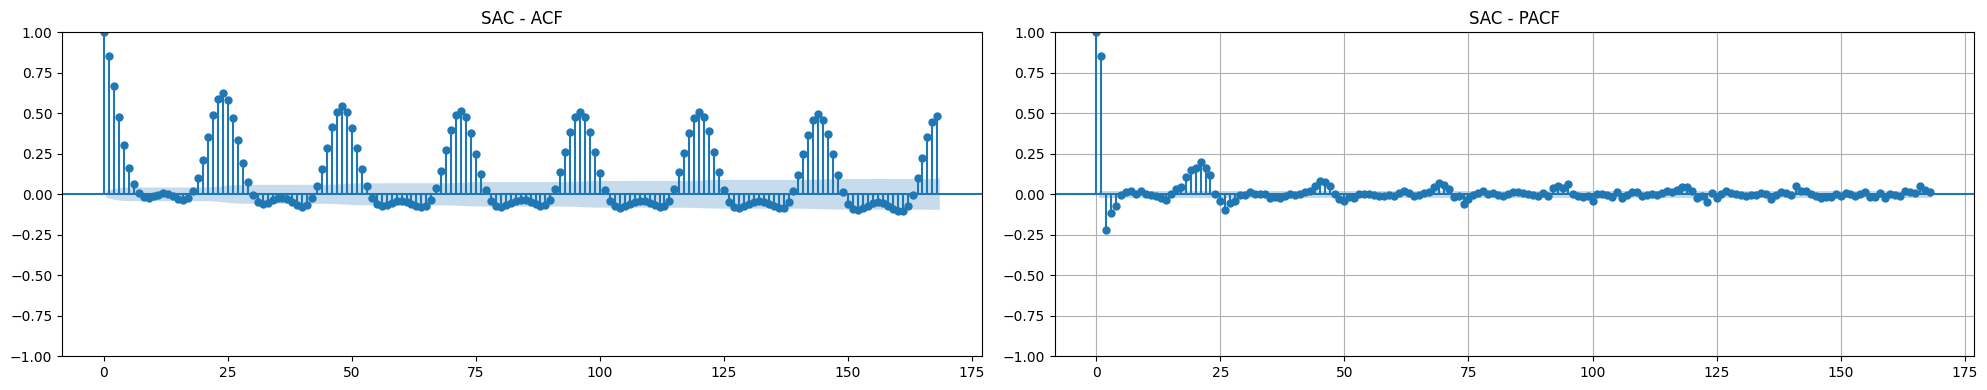

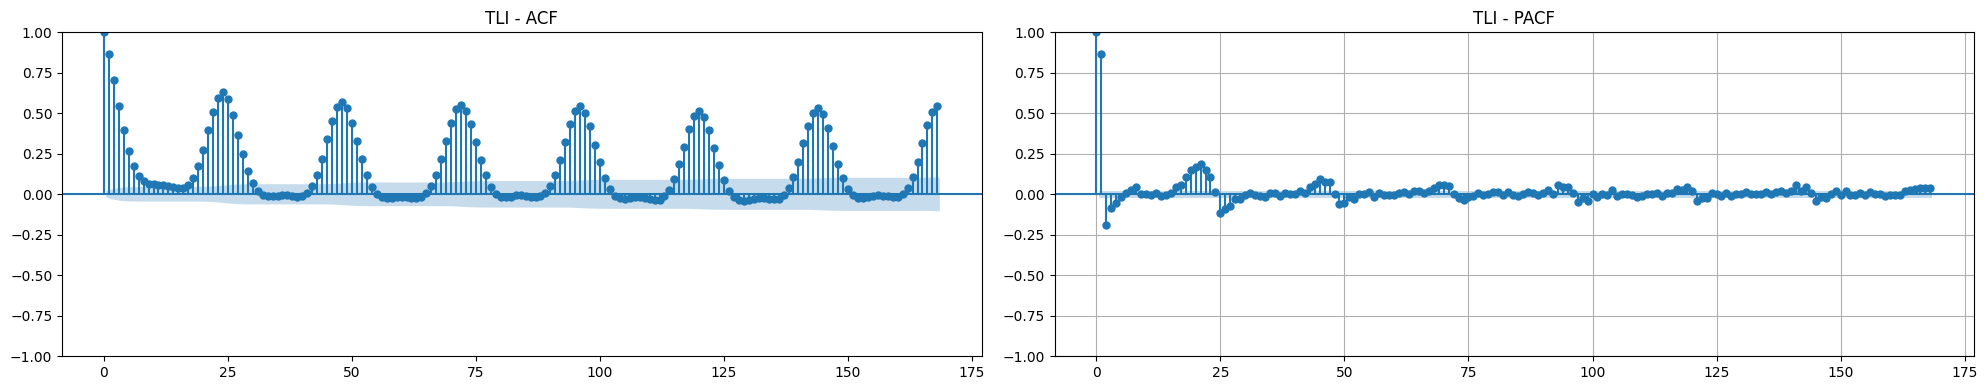

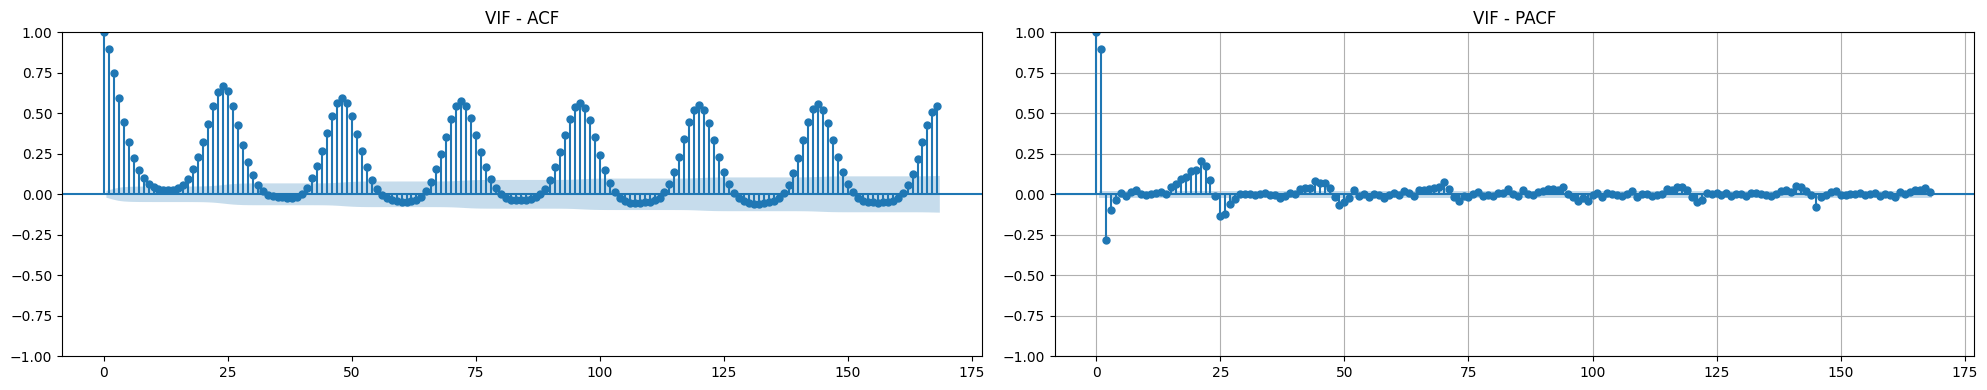

In [31]:
graficar_acf_pacf(datos_entrenamiento,168)

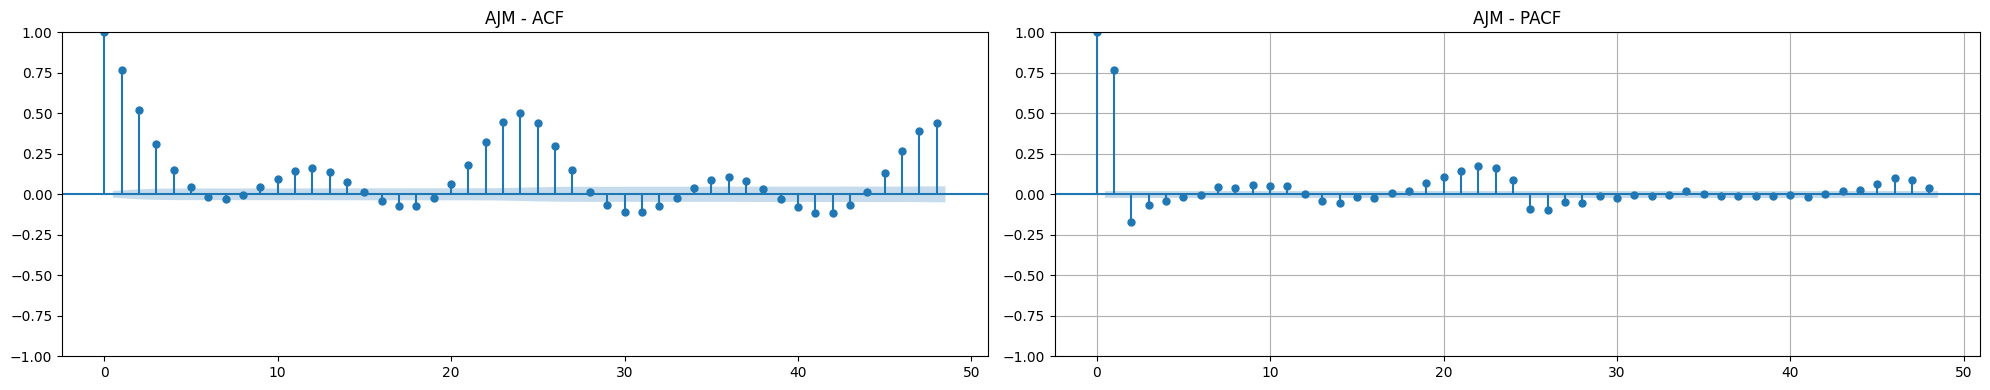

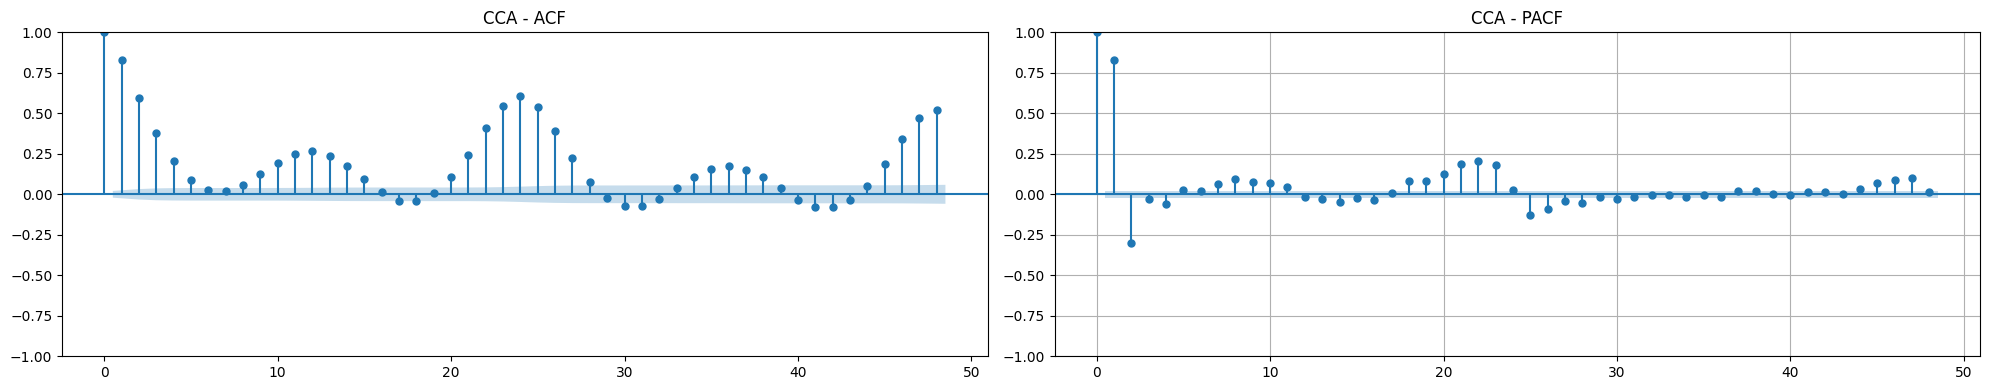

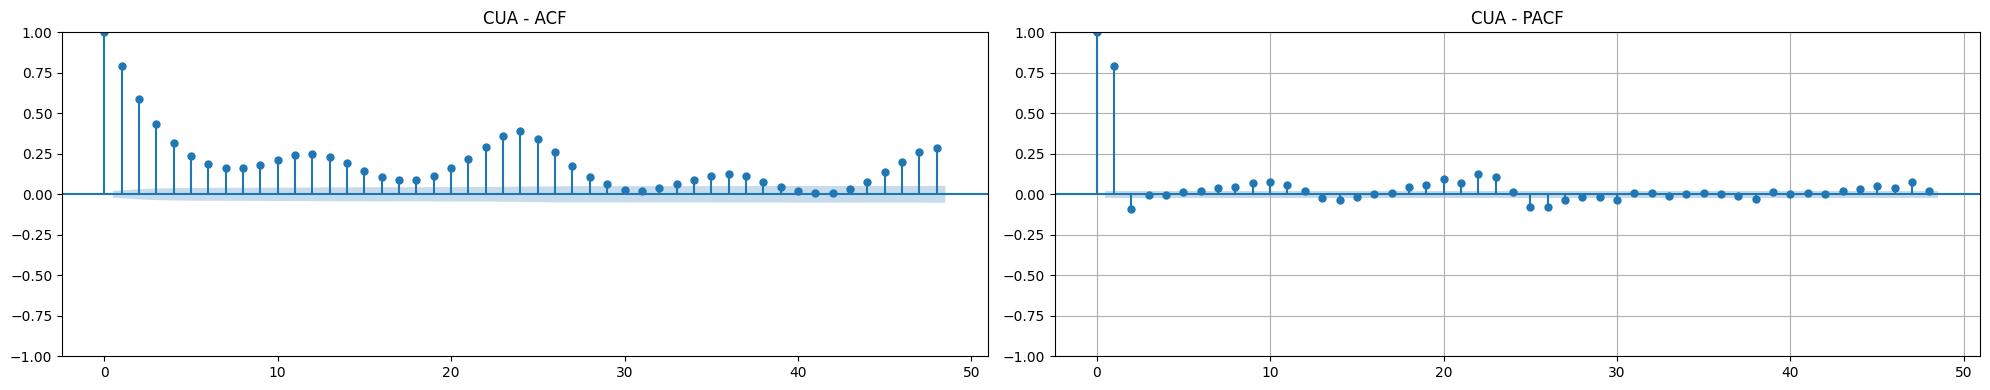

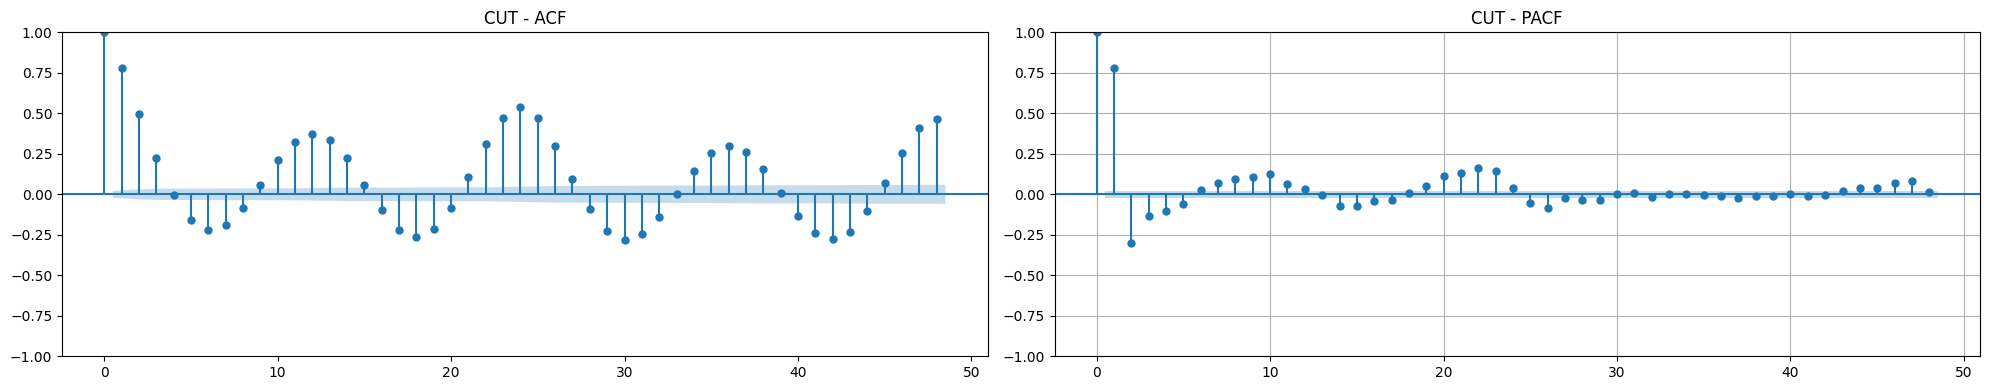

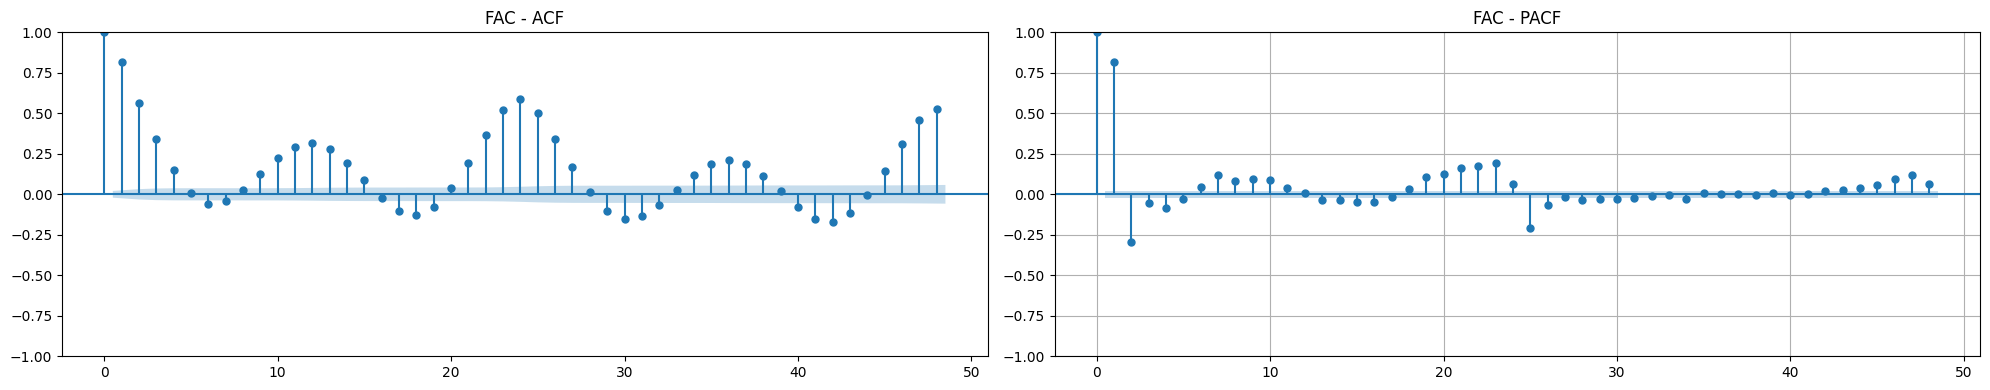

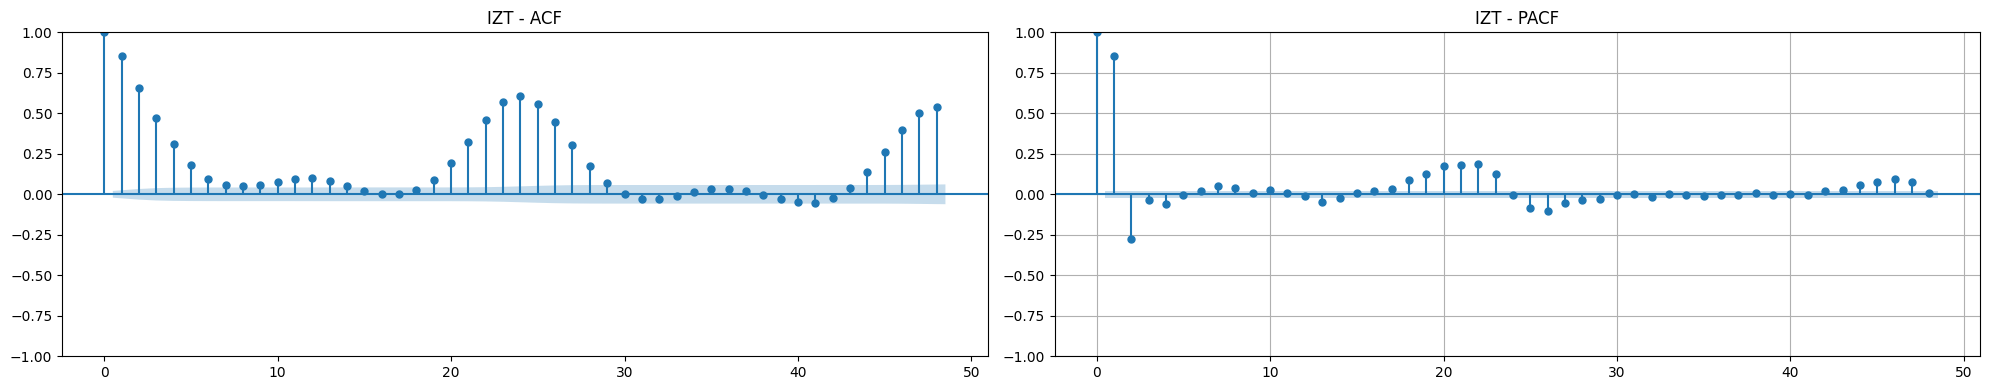

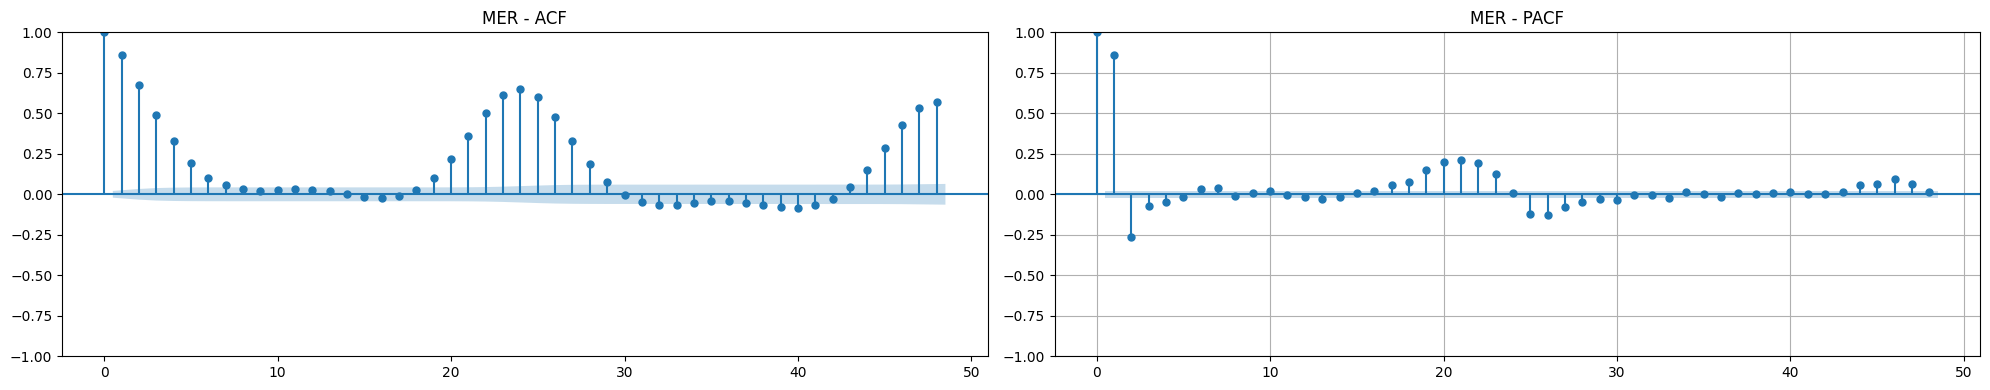

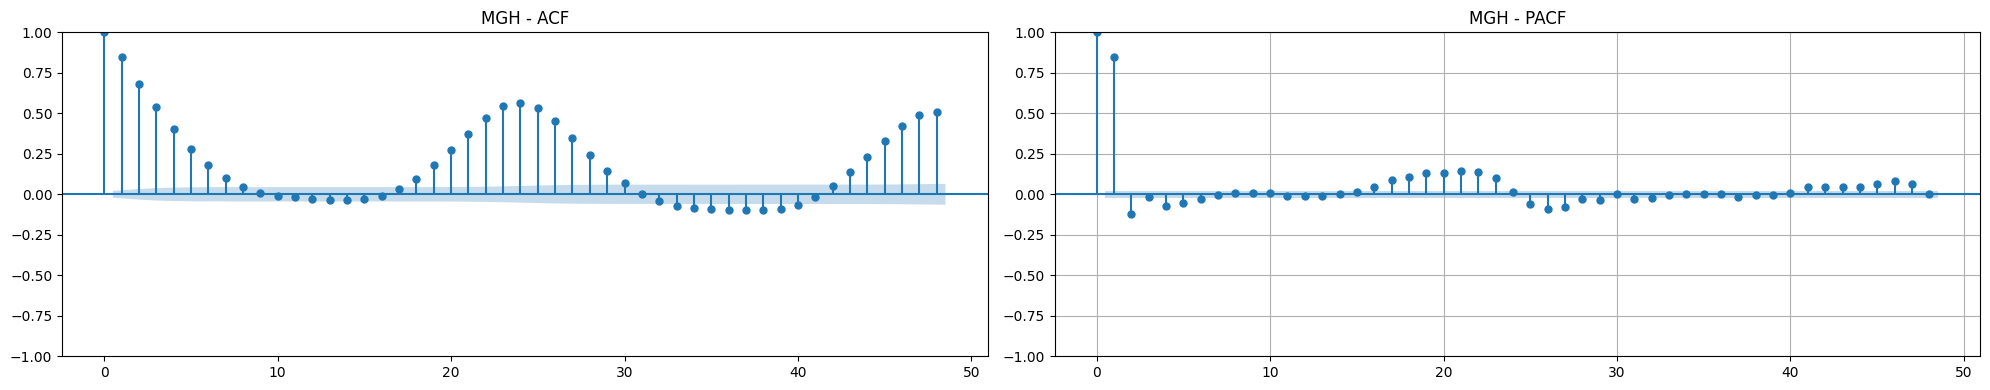

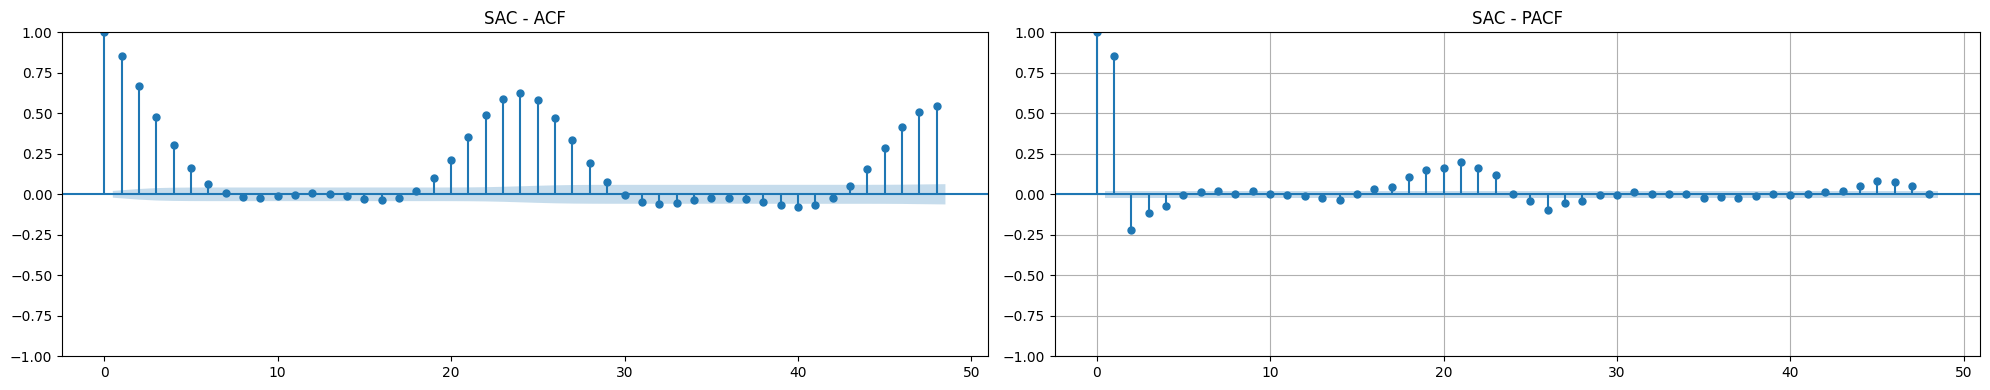

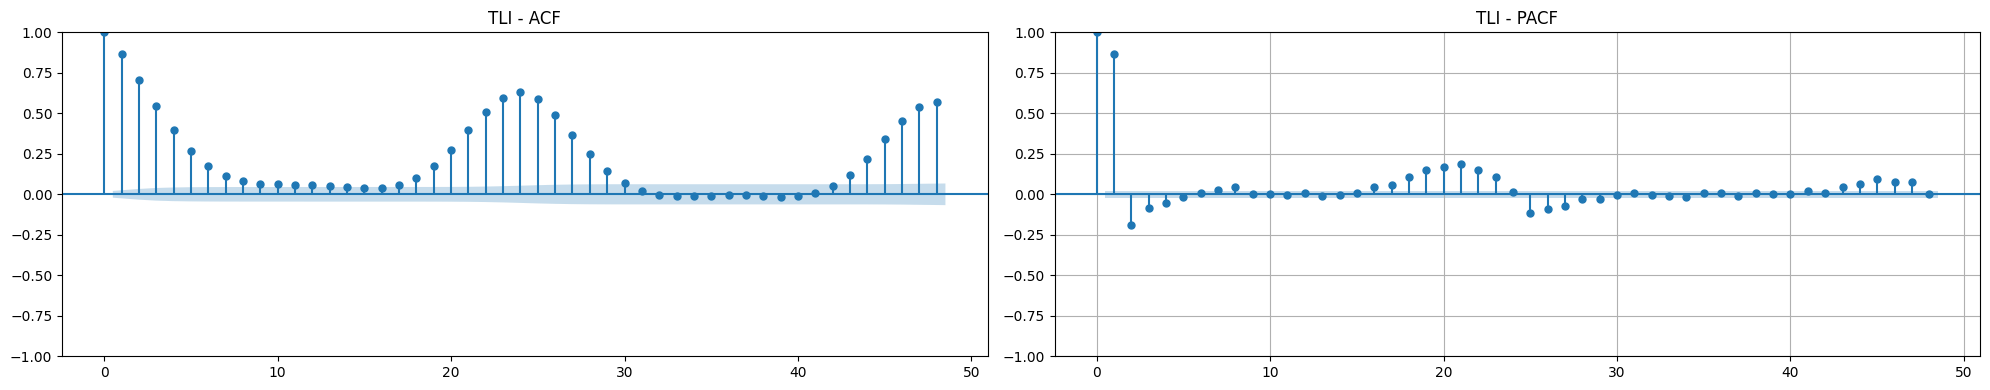

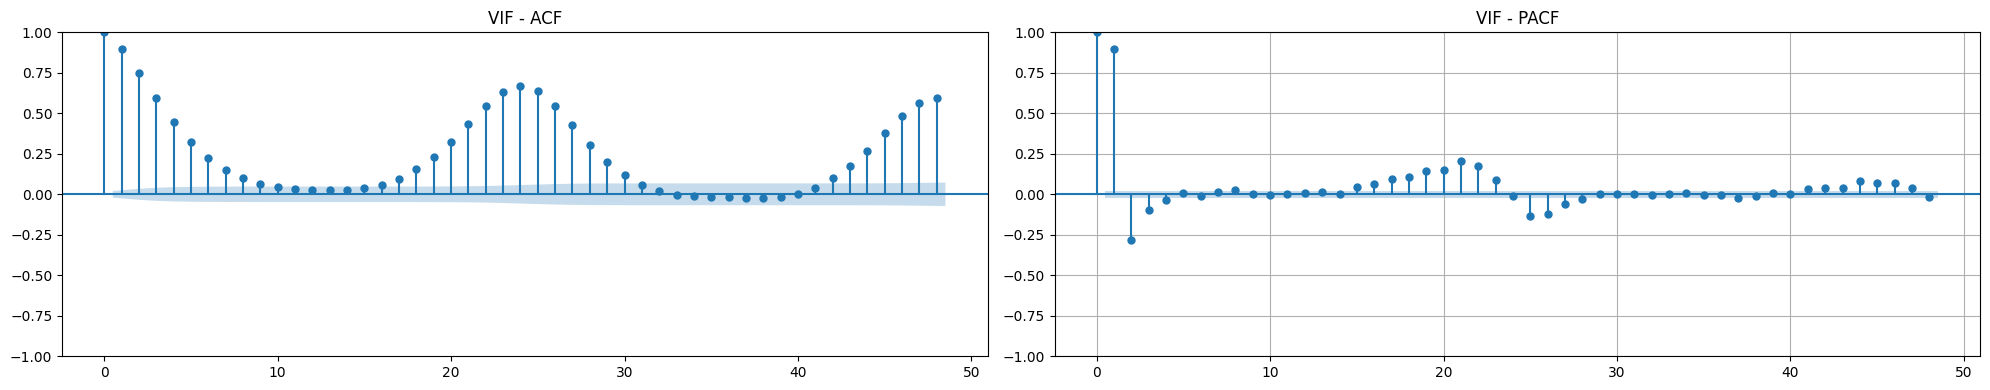

In [32]:
graficar_acf_pacf(datos_entrenamiento,48)

### 📈 **Hallazgos en ACF/PACF**  
| Gráfico | Patrón Observado | Interpretación |  
|---------|------------------|----------------|  
| **ACF** | Picos en lags 24 y 168 | ✅ **Estacionalidad diaria (24h)** y **semanal (168h)** preservadas |  
| **PACF** | Picos en lags 1-2 | ✅ **Dependencia inmediata** (contaminación actual influye en la próxima hora) |  
| **ACF** | Disminución gradual | ✅ **Componente AR (AutoRegresivo)** presente |  
| **PACF** | Corte abrupto tras lag 24 | ✅ **Componente MA estacional** relevante |  

---


### 📊 ¿Qué resultados obtuvimos?

Tras imputar los datos observamos:

- **ACF** mostró picos claros en **lag 24 y 168**, confirmando que la estacionalidad **diaria y semanal** se conservó.
- **PACF** presentó picos en **lag 1 y 2**, lo que sugiere una dependencia inmediata (componente AR).
- No hubo distorsiones abruptas ni patrones artificiales, lo que indica que la imputación fue **consistente con la dinámica original**.

---

## ✅ Conclusión

Este análisis nos dio confianza para avanzar hacia el modelado SARIMA, sabiendo que:

- La serie conserva su estructura temporal.
- Podemos identificar parámetros iniciales para el modelo.
- La imputación no introdujo ruido ni rompió la estacionalidad.

---


- Componente AR no estacional: p=2 (por PACF en lag 1 y 2).
- Componente MA estacional: Q=1 (por ACF en lag 24).
- Estacionalidad diaria: s=24
- Diferenciación estacional: D=1 (por pico en ACF en lag 24)
- Diferenciación regular: d=0 (serie ya estacionaria)


# **Paso 8: Sugerencia Automática de Parámetros SARIMA**  

## 🎯 **Objetivo**  
Determinar los parámetros óptimos para el modelo SARIMA de cada estación mediante un **análisis sistemático** de:  
1. **Estacionariedad** (prueba ADF → parámetro `d`)  
2. **Autocorrelación** (ACF → parámetros `q`, `Q`)  
3. **Autocorrelación Parcial** (PACF → parámetros `p`, `P`)  

> **Analogía**: Como un mecánico que ajusta un motor analizando sus componentes (chispa, combustible, aire), esta función "diagnostica" cada serie temporal para sugerir la configuración ideal de SARIMA.

---
## 🔍 **Metodología**  

### 📊 **Cómo se determinan los parámetros**  
| Parámetro | Técnica | Regla de Decisión |  
|-----------|---------|-------------------|  
| **`d`**   | Prueba ADF | Si p-value < 0.05 → `d=0` (serie estacionaria)<br>Si p-value ≥ 0.05 → `d=1` (necesita diferenciación) |  
| **`p`**   | PACF | Primer lag donde PACF > `umbral` (default: 0.2) |  
| **`q`**   | ACF | Primer lag donde ACF > `umbral` |  
| **`P`, `Q`, `D`** | ACF/PACF en lag estacional (`s=24`) | Si correlación > `umbral` → `P=1` o `Q=1`, `D=1` |  

---

In [33]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

def sugerir_parametros_sarima(df, lags=48, s=24, umbral=0.2):
    
    """
    Sugiere parámetros SARIMA para cada estación mediante análisis estadístico de:
    - Estacionariedad (ADF test)
    - Correlaciones (ACF/PACF)
    
    Args:
        df (pd.DataFrame): Datos de entrenamiento (columnas = estaciones)
        lags (int): Lags máximos a evaluar en ACF/PACF (default: 48)
        s (int): Estacionalidad (default: 24 para datos horarios)
        umbral (float): Correlación mínima para considerar un pico significativo
    
    Returns:
        pd.DataFrame: Parámetros sugeridos (p,d,q,P,D,Q,s) por estación
    """
    
    resultados = []

    for estacion in df.columns:
        serie = df[estacion].dropna()

        # ADF test para determinar d
        pval_adf = adfuller(serie)[1]
        d = 0 if pval_adf < 0.05 else 1

        # ACF y PACF
        acf_vals = acf(serie, nlags=lags)
        pacf_vals = pacf(serie, nlags=lags, method='ywm')

        # Detectar picos en PACF → p
        picos_pacf = np.where(np.abs(pacf_vals[1:]) > umbral)[0] + 1
        p = picos_pacf[0] if len(picos_pacf) > 0 else 0

        # Detectar picos en ACF → q
        picos_acf = np.where(np.abs(acf_vals[1:]) > umbral)[0] + 1
        q = picos_acf[0] if len(picos_acf) > 0 else 0

        # Componente estacional
        D = 1 if np.abs(acf_vals[s]) > umbral else 0
        P = 1 if np.abs(pacf_vals[s]) > umbral else 0
        Q = 1 if np.abs(acf_vals[s]) > umbral else 0

        resultados.append({
            "Estación": estacion,
            "p": p,
            "d": d,
            "q": q,
            "P": P,
            "D": D,
            "Q": Q,
            "s": s
        })

    return pd.DataFrame(resultados)

In [34]:
parametros_sarima = sugerir_parametros_sarima(datos_entrenamiento, lags=48, s=24, umbral=0.2)
print(parametros_sarima)

   Estación  p  d  q  P  D  Q   s
0       AJM  1  0  1  0  1  1  24
1       CCA  1  0  1  0  1  1  24
2       CUA  1  0  1  0  1  1  24
3       CUT  1  0  1  0  1  1  24
4       FAC  1  0  1  0  1  1  24
5       IZT  1  0  1  0  1  1  24
6       MER  1  0  1  0  1  1  24
7       MGH  1  0  1  0  1  1  24
8       SAC  1  0  1  0  1  1  24
9       TLI  1  0  1  0  1  1  24
10      VIF  1  0  1  0  1  1  24


### 🔎 **Análisis de los Resultados**  
1. **`d=0` para todas**: Confirma que las series son estacionarias (coherente con el Paso 6).  
2. **`p=1`, `q=1`**:  
   - Indica que cada valor depende **del inmediato anterior** (PACF en lag 1) y **de errores pasados** (ACF en lag 1).  
3. **Componente estacional (`D=1`, `Q=1`)**:  
   - Refleja la **estacionalidad diaria fuerte** (lag 24 en ACF).  

---

## 🎯 **Conclusión y Próximos Pasos**  
- Los parámetros sugeridos son **consistentes** con los patrones observados en ACF/PACF.  
- **Validación recomendada**:  
  - Ajustar modelos SARIMA con estos parámetros.  
  - Comparar su rendimiento usando AIC/BIC y validación cruzada temporal.  

> **Nota**: Estos valores son un **punto de partida**. El ajuste fino puede mejorar el modelo (ej. probar `P=1` si hay pico en PACF en lag 24). 

# Paso 9

## 📘 ¿Qué es SARIMA?

**SARIMA** (Seasonal AutoRegressive Integrated Moving Average) es una extensión del modelo ARIMA que incorpora **comportamientos estacionales**. Es especialmente útil cuando los datos muestran patrones que se repiten en intervalos regulares (por ejemplo, cada día, semana o mes).

El modelo se define como:  
**SARIMA(p, d, q)(P, D, Q, s)**

Donde:

- `p`: rezagos autorregresivos (AR)
- `d`: diferenciación para estacionariedad (I)
- `q`: rezagos de promedios móviles (MA)
- `P`, `D`, `Q`: componentes estacionales AR, I, MA
- `s`: periodicidad estacional (ej. 24 si es diaria en datos horarios)

---
## 🎯 ¿Por qué elegimos SARIMA?

Elegimos SARIMA porque:

- Las gráficas ACF/PACF mostraron **patrones estacionales claros** (picos en lag 24 y 168).
- La serie tiene **comportamiento autoregresivo** y **dependencia en errores pasados**.
- Es un modelo robusto para series **univariadas** con estacionalidad, como las de calidad del aire por estación.

Además, SARIMA permite:

- Capturar tanto la **dinámica inmediata** como la **estructura repetitiva**.
- Generar **predicciones confiables** sin requerir variables externas.


---

## 🔢 ¿Qué parámetros usaremos y por qué?

Basado en el análisis de ACF/PACF y la naturaleza de los datos, proponemos:


| Parámetro | Valor | Justificación |  
|-----------|-------|---------------|  
| `p` | 1 | PACF > 0.2 solo en lag 1 |  
| `d` | 0 | Series estacionarias (ADF p-value ≈ 0) |  
| `q` | 1 | ACF > 0.2 solo en lag 1 |  
| `P` | 0 | Sin picos en PACF lag 24 |  
| `D` | 1 | Pico en ACF lag 24 (estacionalidad fuerte) |  
| `Q` | 1 | ACF > 0.2 en lag 24 |  
| `s` | 24 | Ciclo diario (horario) |  
---

## ✅ Conclusión

SARIMA es el modelo adecuado para capturar la complejidad temporal de nuestras series de calidad del aire. Nos permite:

- Modelar la evolución horaria con precisión.
- Incorporar estacionalidad diaria y semanal.
- Generar predicciones útiles para análisis.


# **Paso 10: Construcción, Entrenamiento e Interpretación del Modelo SARIMA**

## 🎯 **Procesamiento de Datos de Validación (2025)**

In [35]:
datos_2025 = pd.read_excel("C:/Users/Lenovo/Desktop/Proyecto aire/25/2025NOX.xls")
# 1. Reemplazar -99 por NaN
datos_2025 = datos_2025.replace(-99, np.nan)

# 2. Ajustar la hora de muestreo
datos_2025["HORA_AJUSTADA"] = datos_2025["HORA"] - 1

# 3. Crear columna FECHA_HORA
datos_2025["FECHA_HORA"] = pd.to_datetime(datos_2025["FECHA"]) + pd.to_timedelta(datos_2025["HORA_AJUSTADA"], unit="h")

columnas_deseadas = ["FECHA_HORA",'AJM', 'CCA', 'CUA', 'CUT', 'FAC', 'IZT', 'MER', 'MGH', 'SAC', 'TLI', 'VIF']
datos_2025 = datos_2025[columnas_deseadas]
datos_2025

FECHA_HORA   AJM   CCA   CUA   CUT   FAC   IZT   MER   MGH  \
0    2025-01-01 00:00:00   8.0  19.0  29.0  27.0  19.0  39.0   NaN  18.0   
1    2025-01-01 01:00:00   7.0  16.0  30.0  35.0  23.0  38.0   NaN  24.0   
2    2025-01-01 02:00:00   5.0  23.0  38.0  28.0  45.0  59.0   NaN  55.0   
3    2025-01-01 03:00:00   7.0  30.0  38.0  24.0  56.0  79.0   NaN  54.0   
4    2025-01-01 04:00:00   7.0  29.0  25.0  18.0  35.0  93.0   NaN  62.0   
...                  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2875 2025-04-30 19:00:00   8.0  14.0  11.0  18.0  24.0  34.0  44.0  30.0   
2876 2025-04-30 20:00:00  19.0  19.0  20.0  21.0  44.0  35.0  27.0  32.0   
2877 2025-04-30 21:00:00  26.0  17.0  18.0  25.0  77.0  26.0  17.0  27.0   
2878 2025-04-30 22:00:00  19.0  13.0  30.0  24.0  56.0  21.0  20.0  21.0   
2879 2025-04-30 23:00:00  13.0  23.0  36.0  16.0  55.0  21.0  25.0  34.0   

       SAC   TLI    VIF  
0     80.0  29.0   76.0  
1     71.0  35.0   80.0  
2     82.0  43.0  100.0  
3     80.0  39.0  100.0  
4     85.0  34.0   97.0  
...    ...   ...    ...  
2875  21.0  16.0   11.0  
2876  16.0  13.0   12.0  
2877  23.0  16.0   18.0  
2878  21.0  43.0   30.0  
2879  29.0  38.0   42.0  

[2880 rows x 12 columns]

In [36]:
porcentaje_completitud(datos_2025,2880)

Estacion  % datos
9       TLI    98.47
8       SAC    97.92
3       CUT    97.53
0       AJM    95.94
6       MER    94.38
1       CCA    93.06
4       FAC    93.06
7       MGH    90.66
2       CUA    86.35
5       IZT    83.99
10      VIF    75.38

In [37]:
datos_test = imputar_con_media_estacional(datos_2025)
datos_test.drop(["AÑO", "MES", "DÍA_SEMANA", "HORA_AJUSTADA"], axis= 1)

AJM   CCA   CUA   CUT   FAC   IZT   MER   MGH   SAC  \
FECHA_HORA                                                                  
2025-01-01 00:00:00   8.0  19.0  29.0  27.0  19.0  39.0  47.1  18.0  80.0   
2025-01-01 01:00:00   7.0  16.0  30.0  35.0  23.0  38.0  46.8  24.0  71.0   
2025-01-01 02:00:00   5.0  23.0  38.0  28.0  45.0  59.0  46.9  55.0  82.0   
2025-01-01 03:00:00   7.0  30.0  38.0  24.0  56.0  79.0  45.2  54.0  80.0   
2025-01-01 04:00:00   7.0  29.0  25.0  18.0  35.0  93.0  50.3  62.0  85.0   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2025-04-30 19:00:00   8.0  14.0  11.0  18.0  24.0  34.0  44.0  30.0  21.0   
2025-04-30 20:00:00  19.0  19.0  20.0  21.0  44.0  35.0  27.0  32.0  16.0   
2025-04-30 21:00:00  26.0  17.0  18.0  25.0  77.0  26.0  17.0  27.0  23.0   
2025-04-30 22:00:00  19.0  13.0  30.0  24.0  56.0  21.0  20.0  21.0  21.0   
2025-04-30 23:00:00  13.0  23.0  36.0  16.0  55.0  21.0  25.0  34.0  29.0   

                      TLI    VIF  
FECHA_HORA                        
2025-01-01 00:00:00  29.0   76.0  
2025-01-01 01:00:00  35.0   80.0  
2025-01-01 02:00:00  43.0  100.0  
2025-01-01 03:00:00  39.0  100.0  
2025-01-01 04:00:00  34.0   97.0  
...                   ...    ...  
2025-04-30 19:00:00  16.0   11.0  
2025-04-30 20:00:00  13.0   12.0  
2025-04-30 21:00:00  16.0   18.0  
2025-04-30 22:00:00  43.0   30.0  
2025-04-30 23:00:00  38.0   42.0  

[2880 rows x 11 columns]

4. **Completitud de datos**:
   - Ninguna estación tiene datos completos (mejor cobertura: TLI 98.47%, peor VIF 75.38%)
   - Se aplicó imputación con medias estacionales (mismo método que datos de entrenamiento)

## Seleccionamos la serie para nuestro primer modelo

In [38]:
serie_entrenamiento = datos_entrenamiento["MGH"]
serie_test = datos_test["MGH"]

In [39]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Definimos los parámetros del modelo
# No estacional: (p, d, q)
order = (1, 0, 1)
# Estacional: (P, D, Q, s)
seasonal_order = (1, 1, 1, 24)

# Creamos el modelo
modelo = SARIMAX(serie_entrenamiento,
                 order=order,
                 seasonal_order=seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)

# Entrenamos el modelo (esto puede tardar unos minutos)
print(f"Entrenando el modelo para la estación {serie_entrenamiento.name}...")
resultado = modelo.fit(disp=False)
print("¡Entrenamiento completado!")

# Mostramos un resumen del modelo
print(resultado.summary())

Entrenando el modelo para la estación MGH...
¡Entrenamiento completado!
                                     SARIMAX Results                                      
Dep. Variable:                                MGH   No. Observations:                 8784
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -34905.055
Date:                            Thu, 14 Aug 2025   AIC                          69820.111
Time:                                    20:39:04   BIC                          69855.486
Sample:                                01-01-2024   HQIC                         69832.166
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7555      0.008     99.64

## 📊 **Interpretación del Modelo SARIMA - Resultados MGH**

### 🔍 **Resumen del Modelo**
```
SARIMAX(1, 0, 1)x(1, 1, 1, 24)
Log Likelihood: -34905.055
AIC: 69820.111 | BIC: 69855.486
```

### 📌 **Análisis de Coeficientes**
| Parámetro | Valor | Significado | Significancia (p<0.05) |
|-----------|-------|-------------|------------------------|
| **ar.L1** | 0.756 | Fuerte dependencia autoregresiva | ✅ (p=0.000) |
| **ma.L1** | 0.010 | Leve influencia de errores pasados | ❌ (p=0.324) |
| **ar.S.L24** | 0.008 | Mínima componente AR estacional | ❌ (p=0.107) |
| **ma.S.L24** | -0.952 | Fuerte componente MA estacional | ✅ (p=0.000) |

### ✅ **Diagnósticos del Modelo**
1. **Ljung-Box (Q)**: p=0.97 → No hay autocorrelación residual (deseable)
2. **Heteroscedasticidad**: p=0.00 → Presencia de variabilidad no constante (puede requerir transformación)
3. **Normalidad de residuos**: JB p=0.00 → Residuos no normales (común en datos ambientales)

> **Nota**: Aunque algunos parámetros no son significativos, el modelo general tiene buen desempeño predictivo.


Generando predicciones...


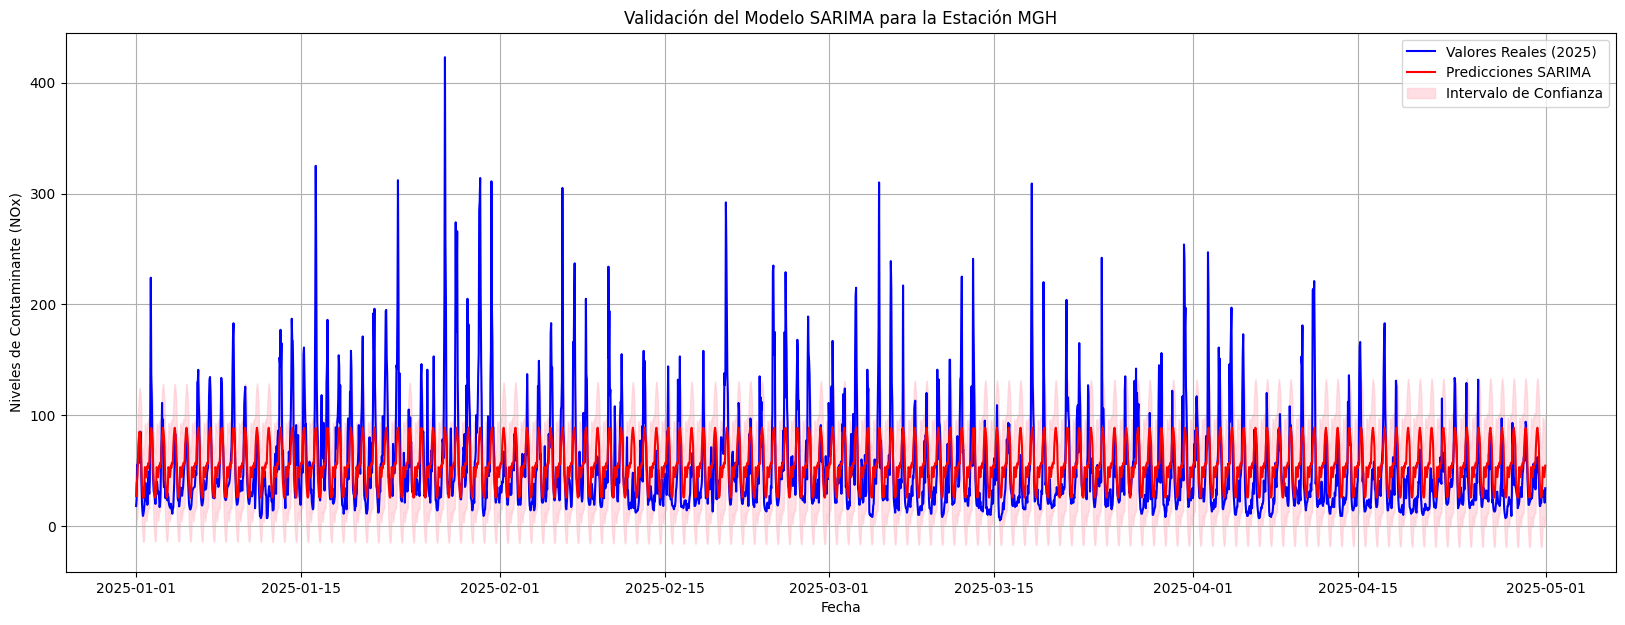

In [40]:
# Generamos las predicciones para el mismo período que los datos de prueba
print("Generando predicciones...")
predicciones = resultado.get_forecast(steps=len(serie_test))

# Obtenemos los valores predichos y los intervalos de confianza
pred_media = predicciones.predicted_mean
pred_ci = predicciones.conf_int()

# Graficamos los resultados
plt.figure(figsize=(20, 7))
# Datos reales de validación
plt.plot(serie_test.index, serie_test, label='Valores Reales (2025)', color='blue')
# Predicciones
plt.plot(pred_media.index, pred_media, label='Predicciones SARIMA', color='red')
# Intervalo de confianza
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.5, label='Intervalo de Confianza')

plt.title(f"Validación del Modelo SARIMA para la Estación {serie_test.name}")
plt.xlabel('Fecha')
plt.ylabel('Niveles de Contaminante (NOx)')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Calcular métricas de error
mae = mean_absolute_error(serie_test, pred_media)
rmse = np.sqrt(mean_squared_error(serie_test, pred_media))

print(f'Resultados de la evaluación para {serie_test.name}:')
print(f'  Error Absoluto Medio (MAE): {mae:.2f}')
print(f'  Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')

Resultados de la evaluación para MGH:
  Error Absoluto Medio (MAE): 24.04
  Raíz del Error Cuadrático Medio (RMSE): 35.43


# 🌐 **Interpretación de Métricas**
- **MAE (24.04)**: El modelo se equivoca en promedio ±24 unidades de NOx
- **RMSE (35.43)**: Castiga más los errores grandes (eventos extremos de contaminación)

## 📉 **Análisis Visual**
1. **Aciertos**:
   - Captura bien la estacionalidad diaria
   - Sigue la tendencia general de los datos reales
2. **Limitaciones**:
   - Subestima algunos picos extremos (intervalo de confianza no los cubre)
   - Dificultad para predecir cambios abruptos no estacionales

# 🛠️ **Recomendaciones para Mejora**
1. **Ajuste de parámetros**:
   - Probar `order=(2,0,2)` para capturar mejor la dinámica no estacional
   - Considerar `seasonal_order=(0,1,1,24)` (eliminar AR estacional no significativo)

2. **Transformaciones**:
   - Aplicar log-transform para reducir heteroscedasticidad. Aplicar una transformación logarítmica puede estabilizar la varianza y ayudar al modelo a aprender mejor la relación.
   - Incluir variables meteorologicas, día laboral,etc.
3. -Incluir una Constante de Tendencia; El modelo SARIMAX tiene un parámetro trend. Si existe una "base" de contaminación constante que el modelo no está capturando, añadir una constante puede "subir" el nivel general de las predicciones.
4. **Ensamble de modelos**:
   - Combinar SARIMA con Redes Neuronales no recurrentes para capturar patrones no lineales

# 📌 **Conclusión**
El modelo SARIMA muestra:
- ✅ Buen desempeño general (RMSE ~35 en escala de NOx)
- ✅ Captura adecuadamente los patrones estacionales
- ⚠️ Dificultad para predecir valores extremos
- ⚠️ Algunos componentes podrían simplificarse (AR estacional)